# Lightcurve Plots

In [14]:
"""
IMPORTS
"""
import numpy as np
import re
import matplotlib.pyplot as plt
import lmfit
from lmfit import Parameters, fit_report, minimize
from lmfit.models import ExponentialModel, GaussianModel, PowerLawModel, ExpressionModel, LinearModel
from scipy.stats import spearmanr

In [15]:
"""
CONSTANTS
"""
beta = 1/3      # spectral index
H0 = 70         # Hubble parameter
WM = 0.3        # Omega(matter)
WV = 0.7        # Omega(Vaccuum)
WR = 0.         # Omega(radiation)
WK = 0.         # Omega curvaturve = 1-Omega(total)
c = 299792.458  # velocity of light in km/sec
Tyr = 977.8     # coefficent for converting 1/H into Gyr
DTT = 0.5       # time from z to now in units of 1/H0
age = 0.5       # age of Universe in units of 1/H0
zage = 0.1      # age of Universe at redshift z in units of 1/H0
a = 1.0         # 1/(1+z), the scale factor of the Universe
az = 0.5        # 1/(1+z(object))
T_s = 10        # chosen early time

In [16]:
"""
FUNCTIONS
"""
# luminosity function
def L(flux, d_l, z, beta):
    
    # empty array for the luminosity
    lum = []
    
    # define luminosity function
    for i in flux:
        
        F = i*1e-29 # convert units to erg s^-1 cm^-2 Hz^-1
        L_f = F*4*np.pi*(d_l**2)*(1+z)**(beta-1)
        lum.append(L_f)
        
    return lum



# luminosity error function
def L_err(flux_err, d_l, z, beta):

    # empty array for the error
    lum_err = []
    
    # define error function
    for j in flux_err:
        
        # convert units to erg s^-1 cm^-2 Hz^-1
        F_err = j*1e-29

        err = F_err*4*np.pi*(d_l**2)*(1+z)**(beta-1)
        lum_err.append(err)
        
    return lum_err



# rest time frame function
def T_rest(time, z):
    
    # empty array for the new times
    time_rest = []
    
    # convert to rest frame
    for k in time:
        
        rest = k/(1+z)
        time_rest.append(rest)
        
    return time_rest

    
    
# weight of the error in luminosity
def weight(lum_err):
    
    # empty array for the weights
    weight_lum = []
    
    # define weight function
    for m in lum_err:
        
        weight = 1/m
        weight_lum.append(weight)
    
    return weight_lum



# simple power law of form L = Nx^-a
def power_law1(time, N, a): 
    
    # empty array for the data
    prediction = []
    
    for n in time:
    
        y = N*np.power(n,a)
        prediction.append(y)
    
    return prediction

In [44]:
"""
TEST BOX FOR TESTING FUNCTIONS
"""

import pandas as pd

df = pd.read_csv('Redshifts_Update.txt', header=None, sep='\n')
df = df[0].str.split(' ', expand=True)

print(df)



UnicodeDecodeError: 'utf-8' codec can't decode byte 0xb1 in position 19: invalid start byte

In [60]:
"""
REDSHIFTS
"""

# open afterglow data
with open("Radio_data_new.txt") as file_1:
    # splits data into lines
    data_1 = file_1.readlines()

names = []
GRB_name_all = []         # names of all GRBs in sample

# generate list of GRBs in sample
for i in data_1:
    
    # splits data into rows
    row = i.split()
    #print(row)
    names.append(row[1])

for GRB in names:
    if GRB not in GRB_name_all:
        GRB_name_all.append(GRB)

# open redshift data

GRB_redshift=[]
Redshift= []        # all redshifts
sample= []
z_sample = []       # redshifts in sample

with open('Redshifts.txt') as fp:

    for line in fp.readlines():
        row=line.split()

        try:
            if float(row[-1]) <10:
                
                z = float(row[-1])
                GRB_redshift.append([row[0], z])     # all GRBs with redshift
                Redshift.append(z)
                
        except:
            pass   


GRB_z = [item for item in GRB_redshift if item[0] in GRB_name_all]


z_all = []          # redshifts of GRBs in sample
GRB_all = []        # GRBs in sample with redshifts
allthings = []

for data in GRB_z:
    z_all.append(data[1])
    GRB_all.append(data[0])
    allthings.append([data[0], data[1]])

print(len(GRB_name_all))

477


In [58]:
"""
LUMINOSITY DISTANCE
"""

# Define constants
H0 = 70         # Hubble parameter
WM = 0.3        # Omega(matter)
WV = 0.7        # Omega(Vaccuum)
WR = 0.         # Omega(radiation)
WK = 0.         # Omega curvaturve = 1-Omega(total)
c = 299792.458  # velocity of light in km/sec
Tyr = 977.8     # coefficent for converting 1/H into Gyr
DTT = 0.5       # time from z to now in units of 1/H0
age = 0.5       # age of Universe in units of 1/H0
zage = 0.1      # age of Universe at redshift z in units of 1/H0
a = 1.0         # 1/(1+z), the scale factor of the Universe
az = 0.5        # 1/(1+z(object))
h = H0/100.
WR = 4.165E-5/(h*h)   # includes 3 massless neutrino species, T0 = 2.72528
WK = 1-WM-WR-WV
age = 0.
n=1000         # number of points in integrals

# empty list for data
d_l_all = []        # all luminosity distances

for z in z_all:

    az = 1.0/(1+1.0*z)
    
    for i in range(n):
        a = az*(i+0.5)/n
        adot = np.sqrt(WK+(WM/a)+(WR/(a*a))+(WV*a*a))
        age = age + 1./adot

    zage = az*age/n
    zage_Gyr = (Tyr/H0)*zage
    DTT = 0.0
    DCMR = 0.0

    # do integral over a=1/(1+z) from az to 1 in n steps, midpoint rule
    for i in range(n):
        a = az+(1-az)*(i+0.5)/n
        adot = np.sqrt(WK+(WM/a)+(WR/(a*a))+(WV*a*a))
        DTT = DTT + 1./adot
        DCMR = DCMR + 1./(a*adot)

    DTT = (1.-az)*DTT/n
    DCMR = (1.-az)*DCMR/n
    age = DTT+zage
    age_Gyr = age*(Tyr/H0)
    DTT_Gyr = (Tyr/H0)*DTT
    DCMR_Gyr = (Tyr/H0)*DCMR
    DCMR_Mpc = (c/H0)*DCMR

    # tangential comoving distance

    ratio = 1.00
    x = np.sqrt(abs(WK))*DCMR
    if x > 0.1:
        if WK > 0:
            ratio =  0.5*(np.exp(x)-np.exp(-x))/x 
        else:
            ratio = np.sin(x)/x
    else:
        y = x*x
        if WK < 0: y = -y
        ratio = 1. + y/6. + y*y/120.
        DCMT = ratio*DCMR
        DA = az*DCMT
        DA_Mpc = (c/H0)*DA
        kpc_DA = DA_Mpc/206.264806
        DA_Gyr = (Tyr/H0)*DA
        DL = DA/(az*az)
        DL_Mpc = (c/H0)*DL

    # luminosuity distance in cm
    d_l = DL_Mpc * 3.08568e24
    
    d_l_all.append(d_l)

GRB_z_d_l = []      # GRB name with corresponding redshift and lum distance

for name, z, d_l in zip(GRB_all, z_all, d_l_all):
    GRB_z_d_l.append([name, z, d_l])
    
#print(len(GRB_z_d_l))

186


In [68]:
"""
DATA FOR SPECIFIC FREQUENCY
"""

# empty array to hold data for 8.46GHz

GRB_name_8 = []
time_array = []
flux_array = []
flux_err_array = []
data_freq_8 = []
            
# loop to get data for given frequency
for i in data_1:
    
    # splits data into rows
    row = i.split()
    
    name = row[1]
    freq = row[4]
    
    # chosen frequency = 8.46GHz
    if freq == '8.46':
        time_raw = float(row[3])
        flux_raw = float(row[5])
        flux_err_raw = float(row[6])
        
        GRB_name_8.append(name)
        time_array.append(time_raw)
        flux_array.append(flux_raw)
        flux_err_array.append(flux_err_raw)
        data_freq_8.append([name, time_raw, flux_raw, flux_err_raw])
        
print(data_freq_8)

[['970111', 91.94, 60.0, 0.0], ['970111', 136.81, 60.0, 0.0], ['970111', 176.93, 120.0, 0.0], ['970228', 6.9, 76.0, 50.0], ['970228', 11.0, 20.0, 40.0], ['970228', 11.9, -24.0, 55.0], ['970228', 14.0, 120.0, 0.0], ['970228', 22.9, 2.0, 36.0], ['970228', 29.7, 4.0, 12.0], ['970228', 32.9, 55.0, 30.0], ['970228', 35.8, 75.0, 0.0], ['970228', 49.8, 69.0, 0.0], ['970228', 60.8, 13.0, 26.0], ['970228', 79.7, 105.0, 0.0], ['970228', 99.6, 25.0, 19.0], ['970228', 181.5, -6.0, 13.0], ['970228', 312.9, 36.0, 0.0], ['970402', 91.62, 189.0, 0.0], ['970508', 5.06, 430.0, 25.0], ['970508', 6.23, 610.0, 33.0], ['970508', 7.59, 520.0, 18.0], ['970508', 7.89, 602.0, 24.0], ['970508', 8.4, 604.0, 56.0], ['970508', 9.95, 610.0, 51.0], ['970508', 12.1, 1270.0, 120.0], ['970508', 12.23, 930.0, 120.0], ['970508', 13.2, 570.0, 42.0], ['970508', 13.59, 880.0, 33.0], ['970508', 14.1, 1260.0, 100.0], ['970508', 14.23, 960.0, 100.0], ['970508', 15.58, 550.0, 44.0], ['970508', 16.06, 470.0, 43.0], ['970508', 16.

7
1
12
2
2
1
5
0
0
11
0
0
0
0
0
0
1
0
0
31
38
56
74
1
0
0
4
1
0
1
1
4
5
0
4
3
2
4
13
2
7
3
1
1
1
1
2
0
0
7
20
27
1
3
0
0
0
4
3
32
0
32
35
35
0
0
1
7
12
1
0
0
0
1
2
17
27
0
32
0
0
0
3
16
19
0
0
9
0
0
5
16
3
1
0
0
1
0
0
0
0
5
2
2
1
1
6
1
1
3
0
0
3
0
1
2
2
4
3
0
3
0
0
6
11
3
4
3
33
0
5
0
2
0
3
3
0
1
0
0
15
0
0
3
0
0
0
0
1
0
15
0
0
0
1
0
0
0
0
4
31
1
1
1
3
5
7
8
2
0
9
0
34
2
3
3
1
2
0
1
3
9
8
5
3
0
1
0
0
0
0
2
0
0
4
10
0
0
10
20
3
2
1
0
0
10
0
0
2
2
1
6
1
0
0
0
1
1
0
9
25
0
1
6
0
0
6
5
0
1
1
1
14
18
1
0
12
32
0
1
6
7
4
9
1
11
1
0
1
6
0
0
9
0
1
1
5
0
4
11
1
0
0
9
4
8
4
0
0
13
27
4
10
0
4
0
6
1
1
1
0
1
0
3
8
0
1
8
0
0
2
6
1
1
0
6
0
3
0
0
2
0
0
0
0
7
37
0
1
0
54
3
0
0
54
10
5
18
41
3
19
16
16
4
0
2
6
0
6
11
20
1
0
0
0
1
0
5
1
2
0
5
3
0
5
1
1
4
0
0
0
0
5
0
1
2
0
8
11
0
6
0
11
0
4
9
0
3
4
7
0
6
0
1
0
0
0
5
19
1
3
0
2
4
0
6
2
9
1
27
0
4
0
4
0
31
0
3
0
5
0
15
1
0
10
1
2
0
14
0
0
0
5
0
3
0
0
6
0
11
21
24
12
14
3
4
6
0
1
18
22
2
5
3
5
0
1
1
8
0
4
0
1
1
0
6
1
13
0
3
0
0
5
2
7
10
1
0
53
0
0
0
0
5
1
3

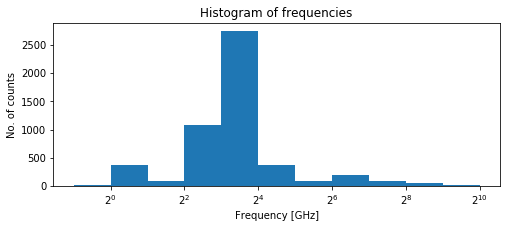

In [80]:
"""
HISTOGRAM OF DATA POINTS
"""

# empty lists for data
names = []
freq_array = []
flux_array = []
data_freq_all = []
freq = []

# split data by GRB
for i in data_1[1:]:
    
    # splits data into rows
    row = i.split()
    flux = float(row[5])
    
    # removes no recorded data entries
    if flux <= 0:
        continue
    
    # adds remaining data points to array
    else:
        freq_array.append(float(row[4]))
        flux_array.append(float(row[5]))
        data_freq_all.append([row[1], float(row[4]), float(row[5])])
        
        freq_test = float(row[4])
        
        if freq_test not in freq:
            freq.append(freq_test)

first_freq = freq[0]
t = 0

for thing in data_freq_all:
    test_freq = thing[1]
    if test_freq == first_freq:
        t += 1
    else:
        print(t)
        t = 0
        first_freq = test_freq

# plot histogram of frequencies for old data
plt.figure(figsize=(8,3))
plt.title('Histogram of frequencies')
plt.hist(freq_array, bins = [0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024])
plt.xlabel("Frequency [GHz]")
plt.semilogx(basex=2)
plt.ylabel("No. of counts")
plt.show()


In [26]:
"""
PLOT OF ALL DATA FOR 8.46GHz
"""

# first GRB in the radio data with a redshift
first_GRB =  GRB_name_all[1]

# empty arrays to store data
time = []
flux = []
flux_err = []
GRB_plot = []
GRB_plot_f = []
GRB_all = []
data_all = []
data_dot = []
data_star = []

# loop through rows in data for 8.46GHz
for row in data_freq_8:
    
    # get name of GRB for that row
    GRB = row[0]
    
    #print(row)
    
    # if GRB matches previous, add it to the array
    if re.match(GRB, first_GRB):
        
        print('yes')
        print(row)
        
    else:
        print('no')
        print(row)
        
        first_GRB = GRB
        continue

"""
        # Adds data to array for that GRB
        t = float(row[1])
        f = float(row[2])
        f_err = float(row[3])
        
        time.append(t)
        flux.append(f)
        flux_err.append(f_err)

        # removes points where error is larger than the recorded value
        if f > f_err:

            # identify redshift and luminosity distance for that GRB
            for j in GRB_z_d_l:

                x = j[0]

                if re.match(first_GRB, x):

                    z = j[1]
                    d_l = j[2]
                    
                    if first_GRB not in GRB_all:
                        GRB_all.append(GRB)
                        
                    
                    
                    #print(GRB)
                    #print(z)
                    #print(d_l)
                    #print(flux)
                    #print(flux_err)
                    #print(time)

                #lum = L(flux, d_l, z, beta)
                #lum_err = L_err(flux_err, d_l, z, beta)
                #time_rest = T_rest(time, z)

                #
                #print(lum)
                
    # when it stops matching, store data for that GRB and reset
    else:
        
        #print(first_GRB)
        #print(time)
        #print(flux)
        #print(flux_err)
        
        time = []
        flux = []
        flux_err = []
        
        first_GRB = GRB

print(GRB_all)
        
"""        
        
        
        
#print(data_all)
                
"""           
        print(GRB)
        print(time)
        print(flux)
        print(flux_err)
        print(z)
        print(d_l)
        
        # call on luminosity function to plot lum curves
        lum = L(flux, d_l, z, beta)
        lum_err = L_err(flux_err, d_l, z, beta)
        time_rest = T_rest(time, z)
        
        print(lum)
        print(lum_err)
        print(time_rest)
        print('END')

        # join the two lists to compare them and check if point is an upper limit
        data_point = list(zip(lum, lum_err, time_rest))

        # compare each lum to it's error
        for data in data_point:
            lum_l = data[0]
            lum_err_l = data[1]
            time_l = data[2]

            # if lum>err, plot as a dot
            if data[0]>data[1]:
                data_dot.append([first_GRB, lum_l, lum_err_l, time_l])

            # if lum<err, plot as an upside down triangle
            if data[1]>data[0]:
                data_star.append([first_GRB, lum_l, lum_err_l, time_l])

            # if lum=err, plot as an upside down triangle since error still won't plot
            if data[1] == data[0]:
                data_star.append([first_GRB, lum_l, lum_err_l, time_l])

        # store all GRB names and data
        GRB_all.append(first_GRB)
                    
        # reset the arrays
        time = []
        flux = []
        flux_err = []
        point = []
        
        # move to next GRB
        first_GRB = GRB
        continue
"""
        
        
        

        
"""     
# plot scatter graph of all data points coloured by GRB
plt.figure(figsize = (12, 8))
plt.title('All of the radio afterglow luminosity light curves from the sample')
plt.xscale("log")
plt.xlabel("Time/1+z [days]")
plt.yscale("log")
plt.ylabel("Luminosity in 8.5GHz band [erg s^-1]")

# loop through data and plot each GRB onto the plot
first_GRB =  GRB_all[0]
lum_j = []
lum_err_j = []
time_j = []

for GRB in GRB_all:
    
    for data in data_dot:
    
        GRB_n = x[0]
    
        if re.match(GRB, GRB_n):
            lum_j.append(x[1])
            lum_err_j.append(x[2])
            time_j.append(x[3])
        
        else:
            plt.scatter(time_j, lum_j, label = f'{GRB}')
            plt.errorbar(time_j, lum_j, lum_err_j, fmt = ' ')
    
            lum_j = []
            lum_err_j = []
            time_j = []
            
    for data in data_star:
        
        GRB_n = x[0]
    
        if re.match(GRB, GRB_n):
            lum_j.append(x[1])
            lum_err_j.append(x[2])
            time_j.append(x[3])
            
        else:
            plt.scatter(time_j, lum_j, label = f'{GRB}')
    
            lum_j = []
            lum_err_j = []
            time_j = []

    first_GRB = GRB
    continue

# plot a vertical line to mark on the early time at which luminosity will be taken
plt.vlines(x=T_s, ymin=1e28, ymax=1e33, colors='grey', linestyles=':', label='T')
plt.legend(bbox_to_anchor = (1 , 1))
plt.show()
  


# plot scatter graph of all data points in same colour
plt.figure(figsize = (12, 8))
plt.title('All of the radio afterglow luminosity light curves from the sample')
plt.xscale("log")
plt.xlabel("Time/1+z [days]")
plt.yscale("log")
plt.ylabel("Luminosity in 8.5GHz band [erg s^-1]")

# loop through data and plot each GRB onto the plot

for x in data_dot:
    
    plt.scatter(x[3], x[1], c="red")
    plt.errorbar(x[3], x[1], x[2], fmt = ' ', c="red")
    
for x in data_star:
   
    plt.scatter(x[3], x[1], marker='v', c="red")

# plot a vertical line to mark on the early time at which luminosity will be taken
plt.vlines(x=T_s, ymin=1e28, ymax=1e33, colors='grey', linestyles=':', label='T')
plt.legend(bbox_to_anchor = (1 , 1))
plt.show()


        

    
    
    

# plot scatter graph of all data points in same colour excluding upper limits
plt.figure(figsize = (12, 8))
plt.title('All of the radio afterglow luminosity light curves from the sample')
plt.xscale("log")
plt.xlabel("Time/1+z [days]")
plt.yscale("log")
plt.ylabel("Luminosity in 8.5GHz band [erg s^-1]")

# loop through data and plot each GRB onto the plot
first_GRB =  GRB_all[0]
lum_j = []
lum_err_j = []
time_j = []

for x in data_dot:
    GRB = x[0]
    
    if GRB == first_GRB:
        lum_j.append(x[1])
        lum_err_j.append(x[2])
        time_j.append(x[3])
        
    else:
        plt.scatter(time_j, lum_j, label = f'{GRB}')
        plt.errorbar(time_j, lum_j, lum_err_j, fmt = ' ')
    
        lum_j = []
        lum_err_j = []
        time_j = []
    first_GRB = GRB
    continue

# plot a vertical line to mark on the early time at which luminosity will be taken
plt.vlines(x=T_s, ymin=1e28, ymax=1e33, colors='grey', linestyles=':', label='T')
#plt.legend(bbox_to_anchor = (1 , 1))
plt.show()
"""

"""
# plot scatter graph of all data points in same colour excluding upper limits and GRB with SNe connection

# GRBs with confirmed SNe connections
GRB_SNe_c = ['011121', '021211', '030329', '031203', '050525A', '060218', '101219B']

# GRBs with suspected SNe connections
GRB_SNe_s = ['090228', '980326', '980425', '990712', '991208', '000911', '020305', '020405', '020903', '030329', '030723', '040924', '041006', '050416A', '050509B', '050824', '080319B', '090618', '091127', '100418A']

# Short GRBs
SHB = ['001025B', '001204', '010119', '020531', '021201', '050202', '050509B', '050709', '050724', '050813', '050906', '050911', '051021A', '051103', '051105A', '051114', '051221A', '051227', '060313', '060502B', '060505', '060801', '061210', '070429B', '070714B', '070724A', '070729', '070923', '071112B', '080503', '080702A', '081024B', '090417B']

# X-Ray Flashes
XRF = ['010213', '011030', '011130', '020427', '020903', '030429', '030528', '030723', '040701', '040812', '040912', '040916', '050215B', '050416A', '050509C', '050522', '051109B', '060218', '060428B']

GRB_list = []
GRB_no_list = []

for GRB in GRB_all:
    if GRB in GRB_SNe_c:
        GRB_no_list.append(GRB)

    if GRB in GRB_SNe_s:
        GRB_no_list.append(GRB)

    if GRB in SHB:
        GRB_no_list.append(GRB)

    if GRB in XRF:
        GRB_no_list.append(GRB)

for GRB in GRB_all:
    if GRB in GRB_no_list:
        continue
    else:
        GRB_list.append(GRB)

plt.figure(figsize = (8, 8))
plt.title('Radio afterglow luminosity light curves from the sample excluding SHB, XRF and GRB with SNe')
plt.xscale("log")
plt.xlabel("Time/1+z [days]")
plt.yscale("log")
plt.ylabel("Luminosity in 8.5GHz band [erg s^-1]")

# loop through data and plot each GRB onto the plot
first_GRB =  GRB_all[0]
lum_j = []
lum_err_j = []
time_j = []

for x in data_dot:
    GRB = x[0]
    
    if GRB in GRB_list:
    
        if GRB == first_GRB:
            lum_j.append(x[1])
            lum_err_j.append(x[2])
            time_j.append(x[3])
            
            

        else:
            plt.scatter(time_j, lum_j, label = f'{GRB}')
            plt.errorbar(time_j, lum_j, lum_err_j, fmt = ' ')
            
            for l_test in lum_j:
                if l_test < 1e29:
                    print(first_GRB)
            
            lum_j = []
            lum_err_j = []
            time_j = []
        first_GRB = GRB
        continue

# plot a vertical line to mark on the early time at which luminosity will be taken
plt.vlines(x=T_s, ymin=1e28, ymax=1e33, colors='grey', linestyles=':', label='T')
# plt.legend(bbox_to_anchor = (1 , 1))
plt.show()
"""

yes
['970111', 91.94, -99.0, 20.0]
yes
['970111', 136.81, -99.0, 20.0]
yes
['970111', 176.93, -99.0, 40.0]
no
['970228', 6.9, 76.0, 50.0]
yes
['970228', 11.0, 20.0, 40.0]
yes
['970228', 11.9, -24.0, 55.0]
yes
['970228', 14.0, -49.0, 40.0]
yes
['970228', 22.9, 2.0, 36.0]
yes
['970228', 29.7, 4.0, 12.0]
yes
['970228', 32.9, 55.0, 30.0]
yes
['970228', 35.8, -43.0, 25.0]
yes
['970228', 49.8, -28.0, 23.0]
yes
['970228', 60.8, 13.0, 26.0]
yes
['970228', 79.7, -79.0, 35.0]
yes
['970228', 99.6, 25.0, 19.0]
yes
['970228', 181.5, -6.0, 13.0]
yes
['970228', 312.9, -99.0, 12.0]
no
['970402', 91.62, -99.0, 63.0]
no
['970508', 5.06, 430.0, 25.0]
yes
['970508', 6.23, 610.0, 33.0]
yes
['970508', 7.59, 520.0, 18.0]
yes
['970508', 7.89, 602.0, 24.0]
yes
['970508', 8.4, 604.0, 56.0]
yes
['970508', 9.95, 610.0, 51.0]
yes
['970508', 12.1, 1270.0, 120.0]
yes
['970508', 12.23, 930.0, 120.0]
yes
['970508', 13.2, 570.0, 42.0]
yes
['970508', 13.59, 880.0, 33.0]
yes
['970508', 14.1, 1260.0, 100.0]
yes
['970508',

['030227', 6.61, 64.0, 24.0]
no
['030323', 3.45, 28.0, 38.0]
no
['030324', 25.97, -99.0, 60.0]
no
['030329', 1.05, 1980.0, 170.0]
yes
['030329', 2.65, 8500.0, 50.0]
yes
['030329', 3.57, 6110.0, 40.0]
yes
['030329', 4.73, 9680.0, 30.0]
yes
['030329', 6.89, 15560.0, 60.0]
yes
['030329', 7.68, 12550.0, 210.0]
yes
['030329', 9.49, 13580.0, 90.0]
yes
['030329', 11.9, 17700.0, 50.0]
yes
['030329', 12.69, 17280.0, 100.0]
yes
['030329', 14.87, 19150.0, 80.0]
yes
['030329', 16.66, 17770.0, 100.0]
yes
['030329', 18.72, 15920.0, 70.0]
yes
['030329', 20.58, 16080.0, 60.0]
yes
['030329', 25.7, 15340.0, 60.0]
yes
['030329', 28.44, 12670.0, 90.0]
yes
['030329', 31.51, 13550.0, 70.0]
yes
['030329', 33.58, 13100.0, 60.0]
yes
['030329', 36.52, 10640.0, 60.0]
yes
['030329', 42.55, 8040.0, 80.0]
yes
['030329', 44.55, 8680.0, 80.0]
yes
['030329', 59.55, 4480.0, 90.0]
yes
['030329', 66.53, 4930.0, 60.0]
yes
['030329', 72.52, 3454.0, 69.0]
yes
['030329', 77.54, 3572.0, 54.0]
yes
['030329', 87.53, 3016.0, 31.

['070612A', 54.77, 883.0, 35.0]
yes
['070612A', 70.53, 984.0, 61.0]
yes
['070612A', 74.66, 1230.0, 42.0]
yes
['070612A', 75.64, 714.0, 42.0]
yes
['070612A', 133.16, 779.0, 40.0]
yes
['070612A', 140.33, 645.0, 41.0]
yes
['070612A', 146.34, 541.0, 45.0]
yes
['070612A', 154.42, 513.0, 43.0]
yes
['070612A', 317.02, 190.0, 37.0]
yes
['070612A', 368.65, 174.0, 43.0]
yes
['070612A', 488.54, 101.0, 39.0]
yes
['070612A', 814.59, 68.0, 49.0]
no
['070714B', 15.52, -42.0, 45.0]
no
['070721B', 12.99, -99.0, 29.0]
no
['070724', 1.07, -99.0, 85.0]
no
['070724B', 11.45, -25.0, 36.0]
no
['070729', 9.49, -71.0, 85.0]
no
['070923', 4.88, -99.0, 45.0]
no
['071003', 1.76, 393.0, 55.0]
yes
['071003', 3.82, 430.0, 50.0]
yes
['071003', 8.72, 431.0, 51.0]
yes
['071003', 11.3, 332.0, 67.0]
yes
['071003', 21.66, 260.0, 42.0]
yes
['071003', 32.68, 109.0, 45.0]
no
['071010A', 1.85, -4.0, 35.0]
no
['071010B', 2.9, 276.0, 49.0]
yes
['071010B', 3.79, 330.0, 52.0]
yes
['071010B', 4.75, 280.0, 40.0]
yes
['071010B', 12.

'\n# plot scatter graph of all data points in same colour excluding upper limits and GRB with SNe connection\n\n# GRBs with confirmed SNe connections\nGRB_SNe_c = [\'011121\', \'021211\', \'030329\', \'031203\', \'050525A\', \'060218\', \'101219B\']\n\n# GRBs with suspected SNe connections\nGRB_SNe_s = [\'090228\', \'980326\', \'980425\', \'990712\', \'991208\', \'000911\', \'020305\', \'020405\', \'020903\', \'030329\', \'030723\', \'040924\', \'041006\', \'050416A\', \'050509B\', \'050824\', \'080319B\', \'090618\', \'091127\', \'100418A\']\n\n# Short GRBs\nSHB = [\'001025B\', \'001204\', \'010119\', \'020531\', \'021201\', \'050202\', \'050509B\', \'050709\', \'050724\', \'050813\', \'050906\', \'050911\', \'051021A\', \'051103\', \'051105A\', \'051114\', \'051221A\', \'051227\', \'060313\', \'060502B\', \'060505\', \'060801\', \'061210\', \'070429B\', \'070714B\', \'070724A\', \'070729\', \'070923\', \'071112B\', \'080503\', \'080702A\', \'081024B\', \'090417B\']\n\n# X-Ray Flashes

In [9]:
"""
FLUX AND LUMINOSITY CURVES (8GHz)
"""

# first GRB in the radio data with a redshift
first_GRB =  GRB_name[0] 

# empty arrays to store data
time = []
flux = []
flux_err = []
GRB_plot = []
GRB_plot_f = []
time_all = []
lum_all = []
lum_err_all = []
data_all = []

# loop through rows in data for 8GHz
for row in data_freq_8:
    
    # get name of GRB for that row
    GRB = row[0]
    
    # if GRB matches previous, add it to the array
    if re.match(GRB, first_GRB):

        # Adds data to array for that GRB
        time.append(row[1])
        flux.append(row[2])
        flux_err.append(row[3])

        # identify redshift and luminosity distance for that GRB
        for j in GRB_z_d_l:

            x = j[0]

            if re.match(GRB, x):

                z = j[1]
                d_l = j[2]


    # when it stops matching, plot the data and reset the arrays  
    else:

        if len(flux) >= 3:

            """
            # plot scatter graph of the individual flux curves
            f = plt.figure()
            f.set_figwidth(8) 
            f.set_figheight(5)
            plt.title(f'Flux in the 8GHz band for GRB{first_GRB}')
            plt.scatter(time, flux, label=flux)
            plt.errorbar(time, flux, yerr = flux_err, fmt = ' ')
            plt.xscale("log")
            plt.xlabel("Time [days]")
            plt.yscale("log")
            plt.ylabel(r'Flux in 8.5GHz band [$\mu$Jy]')
            plt.legend()
            plt.show()
            """
            print(first_GRB)
            print(flux)
            print(flux_err)

            # adds GRB to list if flux curve is plot
            GRB_plot_f.append(first_GRB)

            # call on luminosity function to plot lum curves
            lum = L(flux, d_l, z, beta)
            lum_err = L_err(flux_err, d_l, z, beta)
            time_rest = T_rest(time, z)

            print(lum)
            print(lum_err)
            print(time_rest)
            print(z)

            # defining min and max values for plotting of T_s line
            ymin_T_s = 0.5*min(lum)
            ymax_T_s = 2*max(lum)


            # plot scatter graph of the individual luminosity curves
            f = plt.figure()
            f.set_figwidth(8) 
            f.set_figheight(5)
            plt.title(f'Luminosity in the 8.46GHz band for GRB{first_GRB}')
            plt.scatter(time_rest, lum, label='data')
            plt.errorbar(time_rest, lum, yerr = lum_err, fmt = ' ')
            plt.xscale("log")
            plt.xlabel("Time/(1+z) [days]")
            plt.yscale("log")
            plt.ylabel("Luminosity in 8.46GHz band [erg s^-1]")
            plt.vlines(x=T_s, ymin=ymin_T_s, ymax=ymax_T_s, colors='black', linestyles='solid', label='T_s')
            plt.legend()
            plt.show()

            #print(lum)
            #print(lum_err)
            #print(time)

            # adds GRB to list if luminosity curve is plot
            GRB_plot.append(first_GRB)

        # reset the arrays
        time = []
        flux = []
        flux_err = []

        # move to next GRB
        first_GRB = GRB
        continue

print(len(GRB_plot))

NameError: name 'GRB_name' is not defined

In [10]:
"""
NO. OF GRBS PLOT
"""

# empty lists
no_GRB = []

# names of all GRBs with 8GHz curve
for GRB in GRB_plot:
    if GRB not in no_GRB:
        no_GRB.append(GRB)

print("8GHz GRBs:")
print(no_GRB)

print("The number of GRBs with 8GHz lightcurves is", len(no_GRB))


NameError: name 'GRB_plot' is not defined

/Applications/anaconda3/lib/python3.6/site-packages/lmfit/confidence.py:310: UserWarning: maxiter=200 reached and prob(pow_amplitude=6.61553496152178e+29) = 0.6535506780994654 < max(sigmas).
  warn(errmsg)


[[(0.68, 2.8683835840066142e+20), (0.0, 1.6057123693014075e+28), (0.68, inf)], [(0.68, -0.5196482628934432), (0.0, 0.7724997334381305), (0.68, 5.1581713953431025)]]


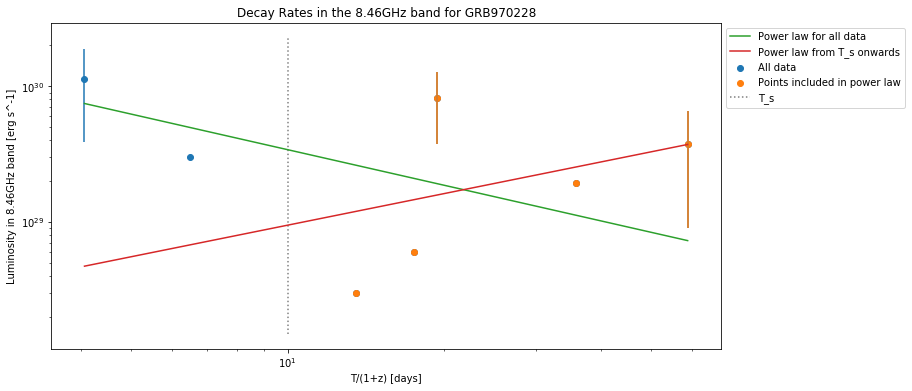

[[(0.68, 6.482236131911555e+31), (0.0, 7.562944080871536e+31), (0.68, 8.842810867133264e+31)], [(0.68, -0.60053890512523), (0.0, -0.5515908279694555), (0.68, -0.5047006421578444)]]


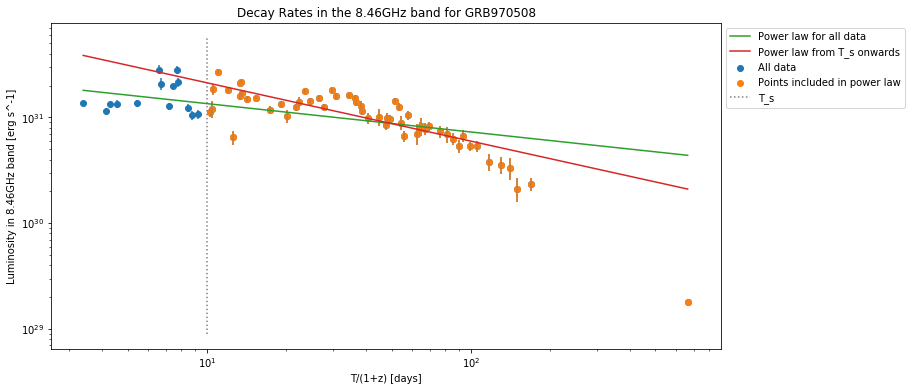

[[(0.68, 6.872906314103941e+27), (0.0, 4.742420466947803e+28), (0.68, 2.3860338569103384e+29)], [(0.68, 0.3035149490998022), (0.0, 0.7617231853223283), (0.68, 1.2914050164222672)]]


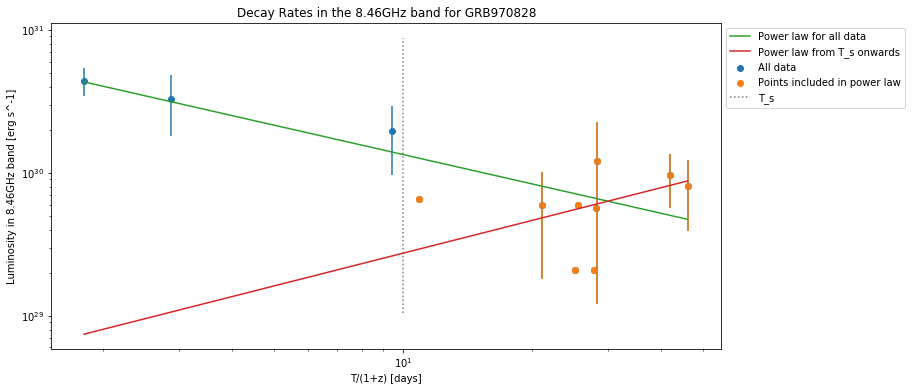

[[(0.68, 6.621127126868237e+32), (0.0, 1.0319735057681806e+33), (0.68, 1.8008211526683416e+33)], [(0.68, -1.1759638910495256), (0.0, -0.9710625295713952), (0.68, -0.81328520465754)]]


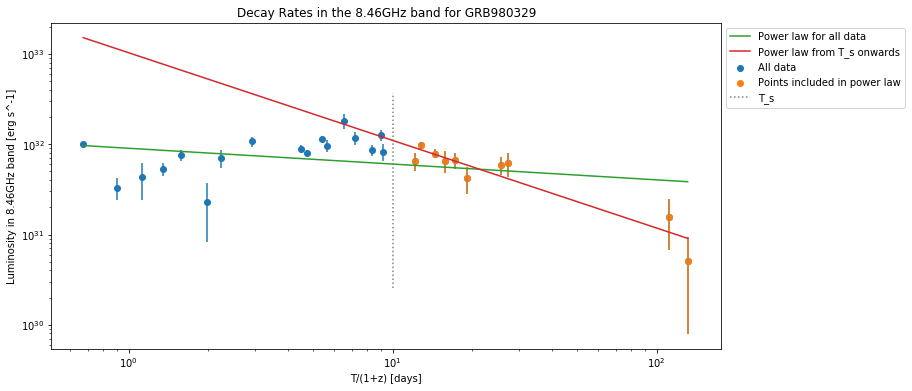

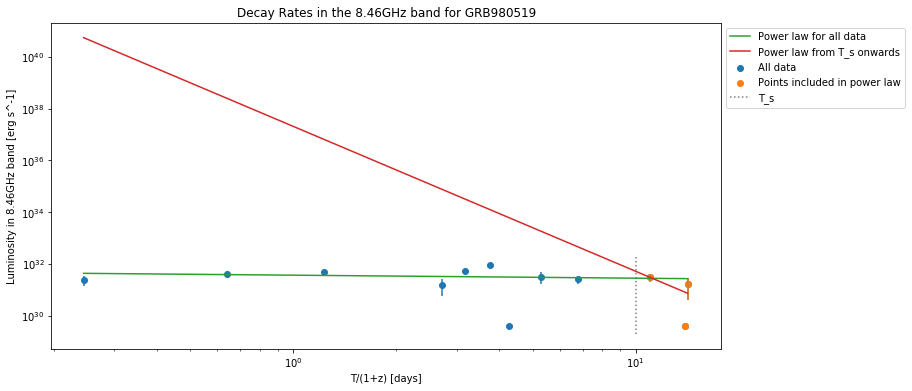

[[(0.68, 1.2815002104170279e+32), (0.0, 1.4773807818085885e+32), (0.68, 1.7126801382616825e+32)], [(0.68, -0.9142029388045165), (0.0, -0.8641328867823919), (0.68, -0.8171242088065054)]]


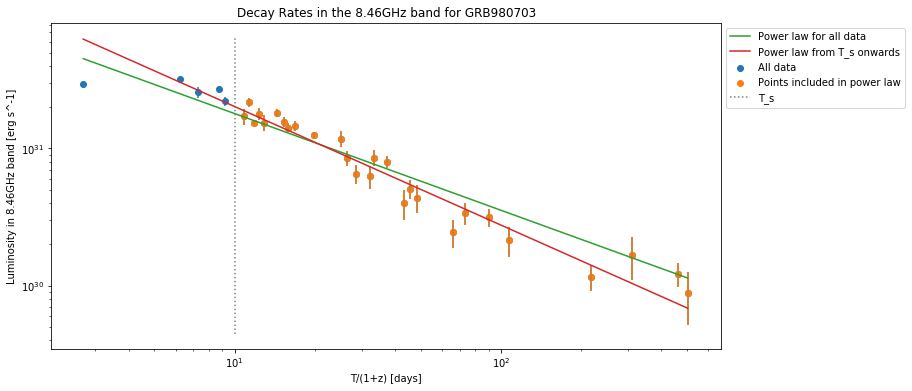

[[(0.68, 1.2853496463389576e+30), (0.0, 3.3353738393104687e+30), (0.68, 1.52484541149865e+31)], [(0.68, -1.0929371782874682), (0.0, -0.5084984958915614), (0.68, -0.18092019389753333)]]


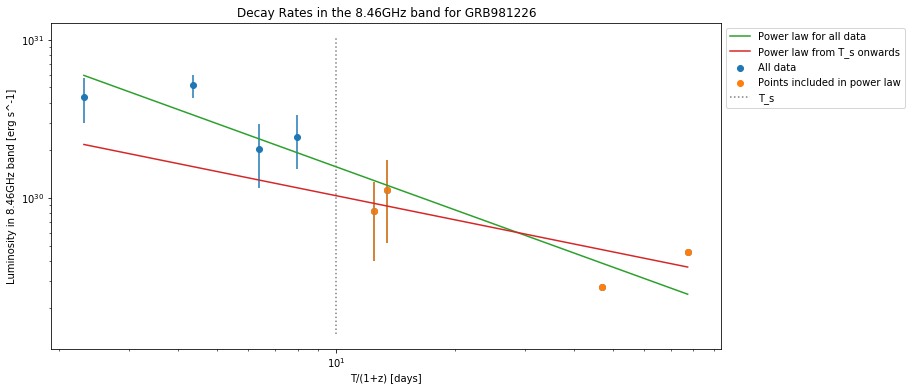

[[(0.68, 7.868228828249713e+30), (0.0, 2.4218295231382554e+31), (0.68, 1.5393287139059856e+32)], [(0.68, -1.8067557533918857), (0.0, -1.0637737409398627), (0.68, -0.6433573346725039)]]


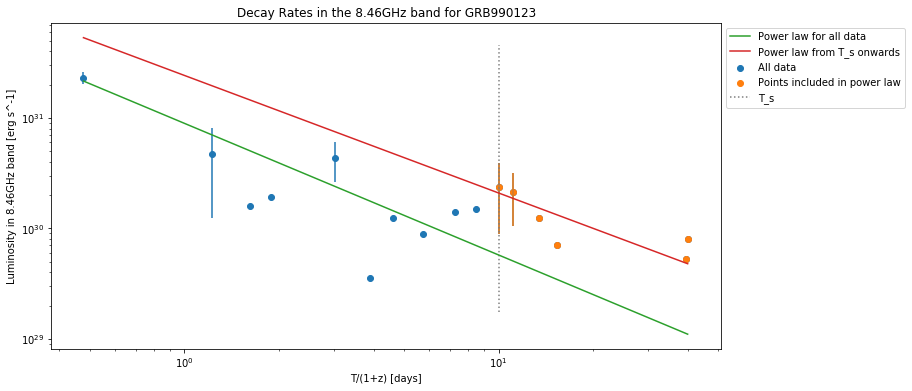

[[(0.68, 4.387078286462408e+27), (0.0, 5.213039850040127e+29), (0.68, 4.600695178310603e+30)], [(0.68, -0.3176243277818935), (0.0, 0.31631968368781616), (0.68, 1.5107008204640735)]]


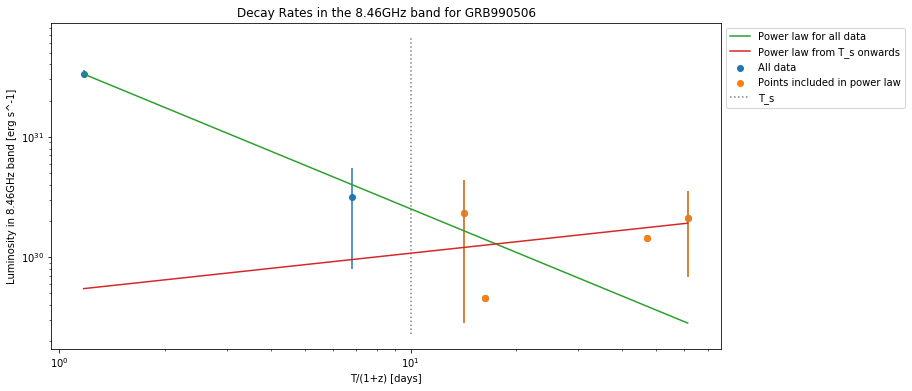

[[(0.68, 7.499213276134936e+31), (0.0, 9.456386528102408e+31), (0.68, 1.1993056196913292e+32)], [(0.68, -0.9492436214154686), (0.0, -0.8714535505008847), (0.68, -0.7978232106709197)]]


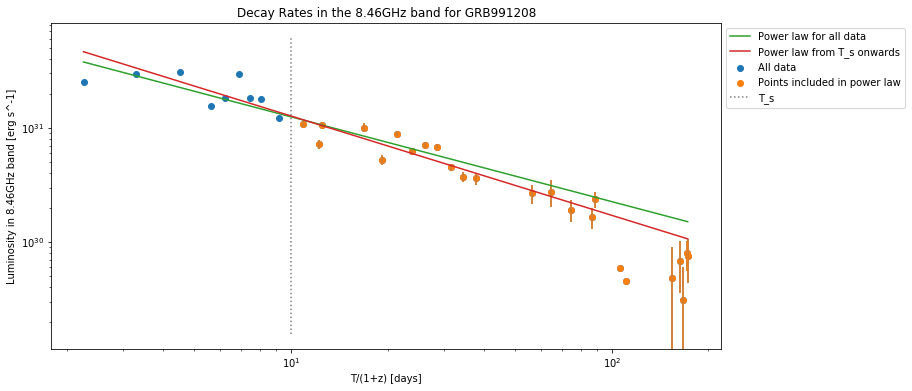

[[(0.68, 4.8493951966662073e+30), (0.0, 1.8402697658130177e+31), (0.68, 7.503261541401888e+31)], [(0.68, -1.447917043917051), (0.0, -0.9150257318515383), (0.68, -0.47363037467868535)]]


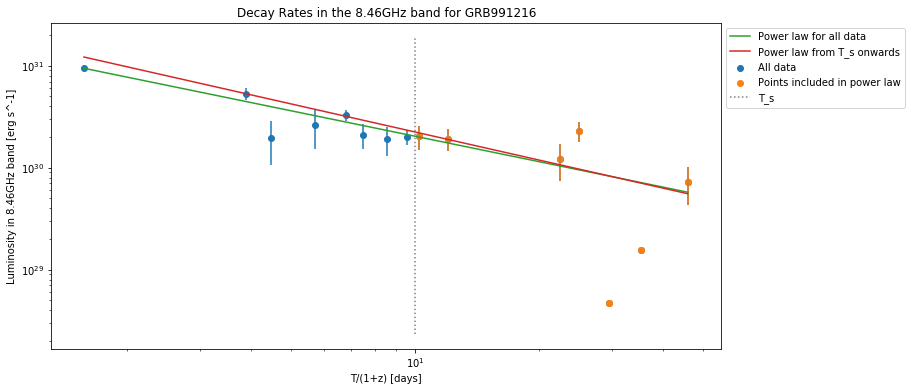

[[(0.68, 8.625828385350303e+29), (0.0, 2.2156161718170848e+30), (0.68, 4.4605152398959884e+30)], [(0.68, -0.3546618515812491), (0.0, -0.19827037860545244), (0.68, -0.018022733804949655)]]


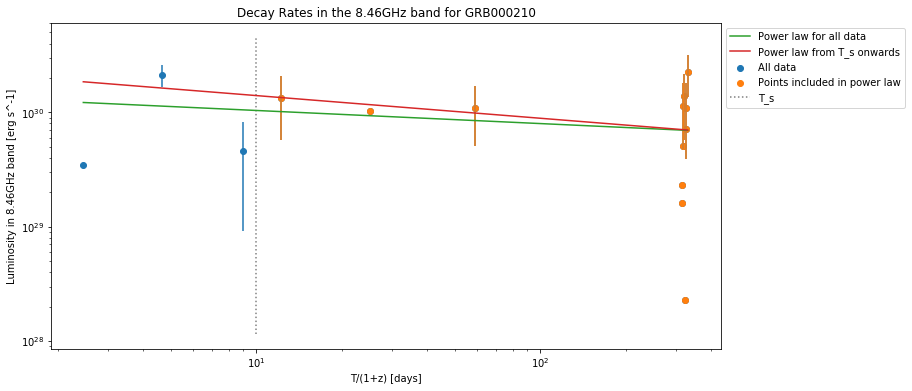

[[(0.68, 3.2341125164586547e+32), (0.0, 4.985994607186179e+32), (0.68, 7.880597294961055e+32)], [(0.68, -1.212903137828356), (0.0, -1.0556754785111553), (0.68, -0.9127624965947245)]]


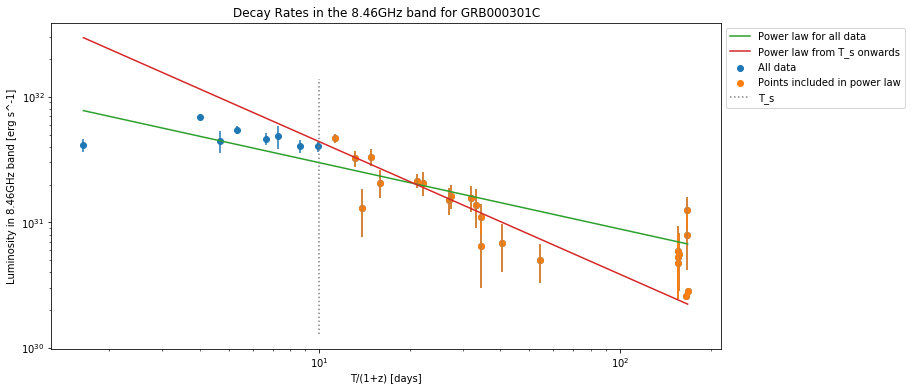

[[(0.68, 7.092155121321433e+32), (0.0, 9.142701627234944e+32), (0.68, 1.1848360460121444e+33)], [(0.68, -1.3504471263843547), (0.0, -1.2668694546316654), (0.68, -1.186627072720236)]]


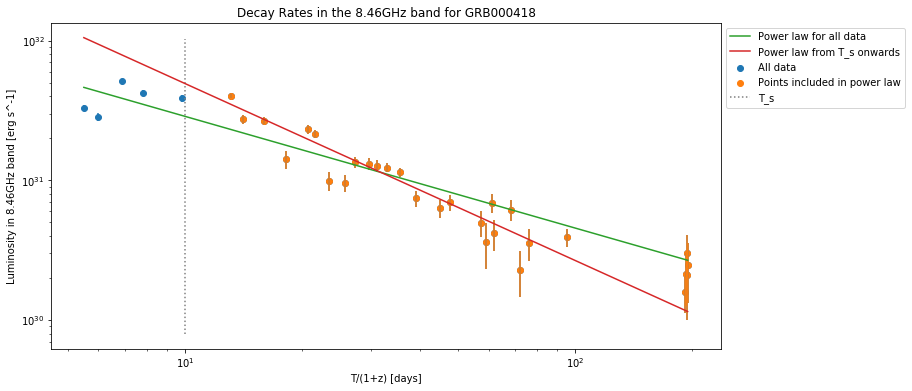

[[(0.68, 5.732408277441857e+30), (0.0, 1.0411868101389872e+31), (0.68, 2.1345290405879537e+31)], [(0.68, -0.8976941201421192), (0.0, -0.620020522532674), (0.68, -0.40556545132349103)]]


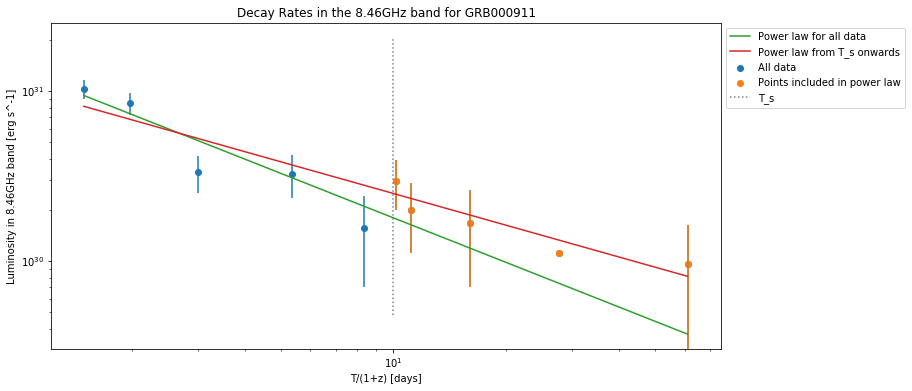

[[(0.68, 1.0317788940950629e+32), (0.0, 1.8780997243656446e+32), (0.68, 3.2683595033554185e+32)], [(0.68, -0.8954057103772134), (0.0, -0.7316429171055293), (0.68, -0.5656266455511685)]]


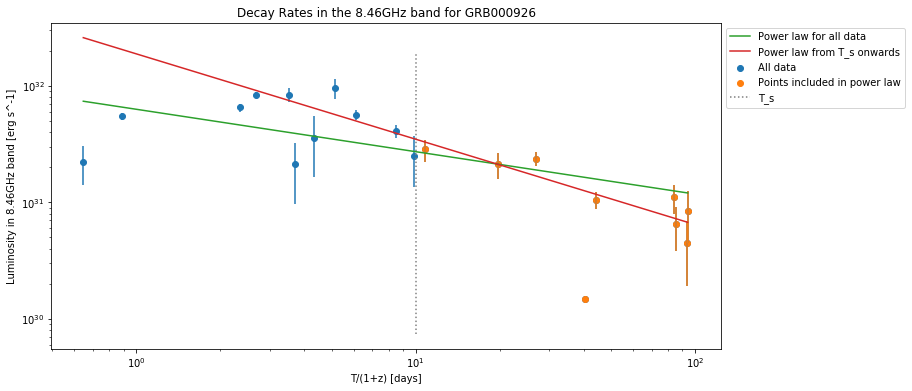

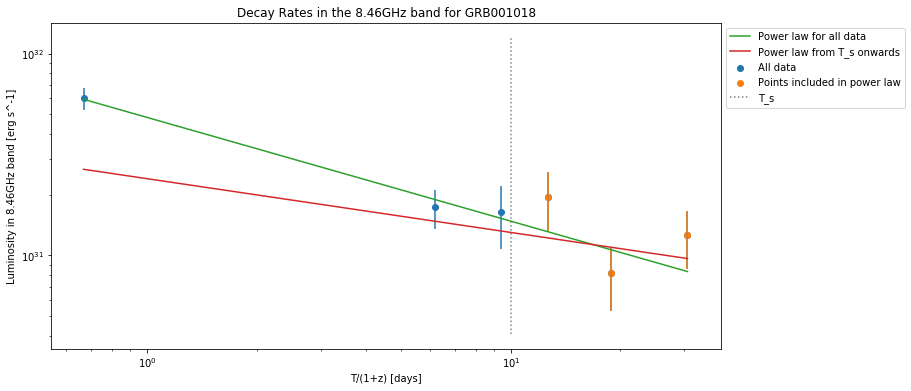

[[(0.68, 5.026763225794708e+30), (0.0, 1.0776659465016228e+31), (0.68, 2.1537224118482205e+31)], [(0.68, -0.6544915158687702), (0.0, -0.44601910801334826), (0.68, -0.23367669192684262)]]


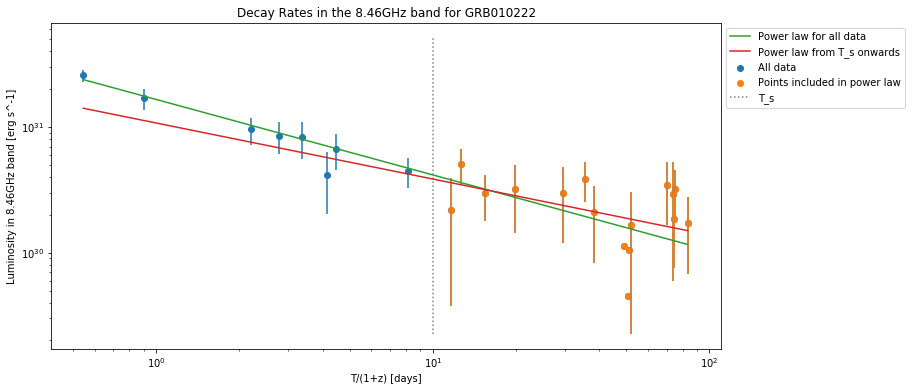

[[(0.68, 2.3442521798986344e+31), (0.0, 3.525991656369588e+31), (0.68, 5.384566232228936e+31)], [(0.68, -1.2558404782760264), (0.0, -1.1312394570420303), (0.68, -1.0142141519739918)]]


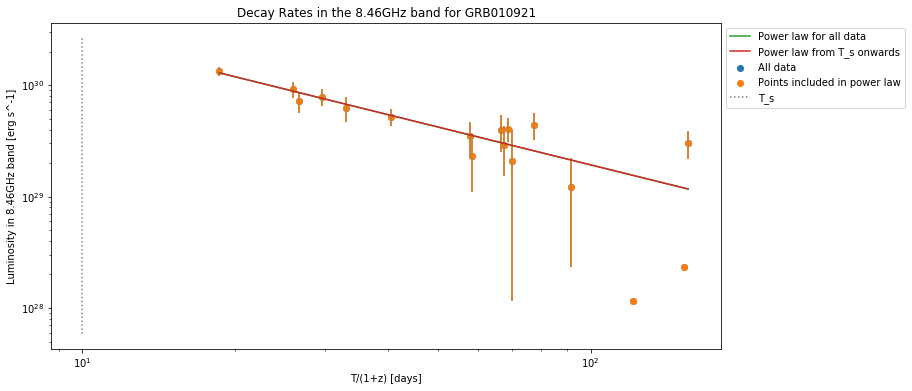

[[(0.68, 1.802776599361487e+30), (0.0, 3.433047378468596e+30), (0.68, 6.795413112976905e+30)], [(0.68, -0.8564973553247613), (0.0, -0.6255314268338411), (0.68, -0.41850000330851145)]]


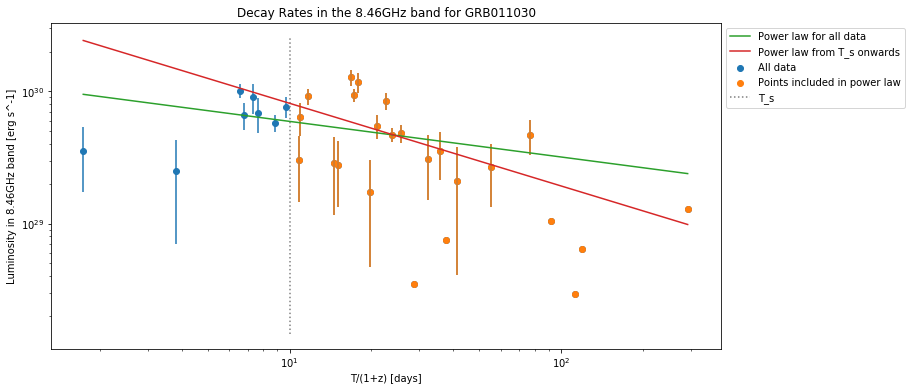

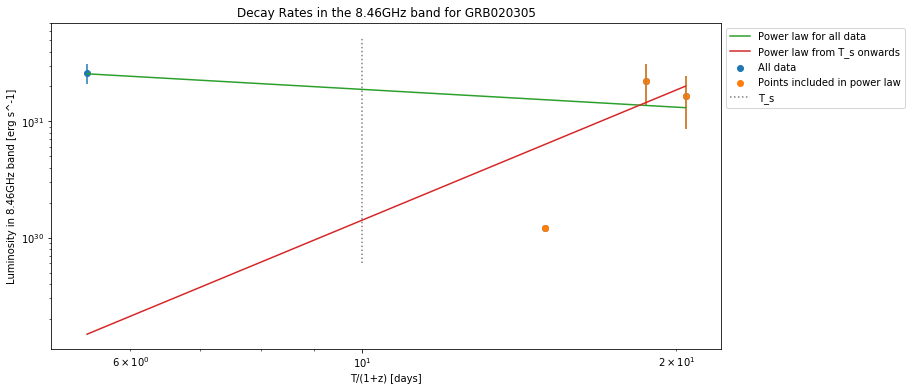

/Applications/anaconda3/lib/python3.6/site-packages/lmfit/confidence.py:310: UserWarning: maxiter=200 reached and prob(pow_amplitude=6.15752290593636e+33) = 0.46656979603666227 < max(sigmas).
  warn(errmsg)


[[(0.68, 3.71746380412613e+29), (0.0, 1.4945443946447396e+32), (0.68, inf)], [(0.68, -4.37827060428871), (0.0, -1.7485904448184668), (0.68, 0.11550554490129891)]]


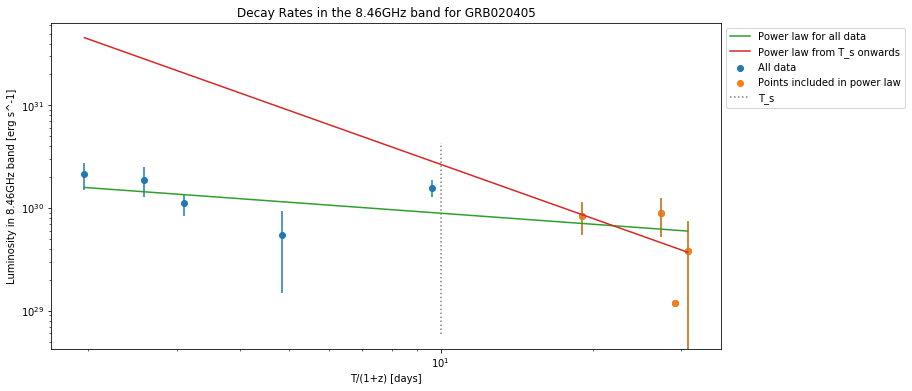

/Applications/anaconda3/lib/python3.6/site-packages/lmfit/confidence.py:310: UserWarning: maxiter=200 reached and prob(pow_amplitude=2.137224253729907e+33) = 0.5020211004260927 < max(sigmas).
  warn(errmsg)


[[(0.68, 1.4629282421339729e+29), (0.0, 5.187437509053161e+31), (0.68, inf)], [(0.68, -3.563361155313154), (0.0, -1.2754922836118965), (0.68, 1.5910522593317746)]]


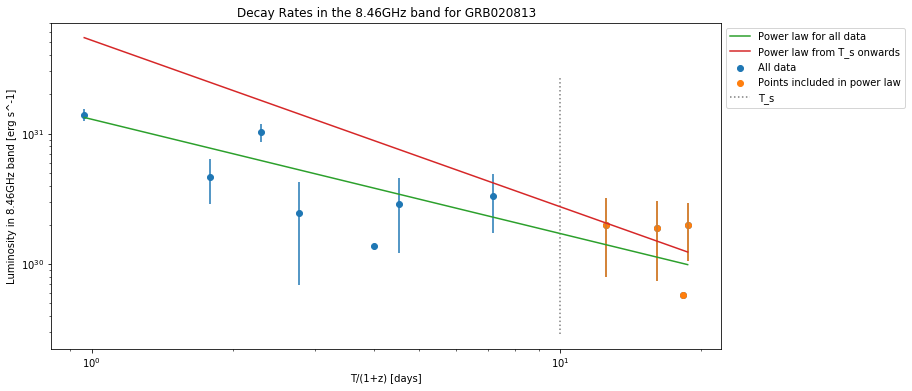

[[(0.68, 1.2336307778944129e+31), (0.0, 4.314440499705911e+31), (0.68, 2.1020317927599133e+32)], [(0.68, -1.3745518303803963), (0.0, -0.8015713059813374), (0.68, -0.42259616819181794)]]


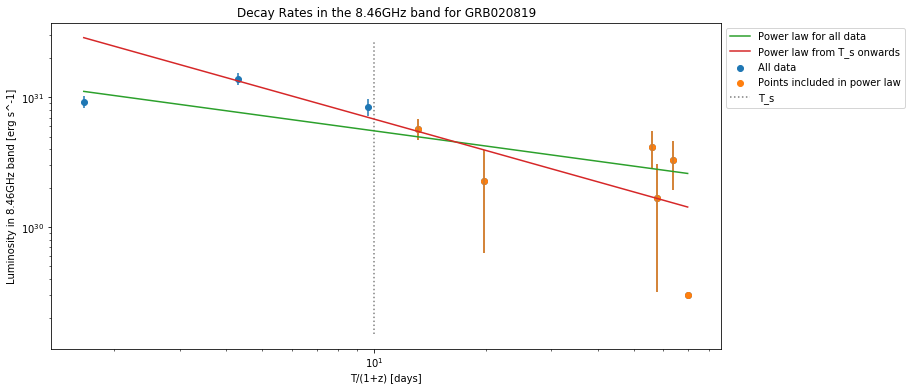

[[(0.68, 2.9197654426509306e+32), (0.0, 7.84487530259671e+32), (0.68, 2.603323869746829e+33)], [(0.68, -1.6593260521612552), (0.0, -1.191500436644246), (0.68, -0.8197454127875287)]]


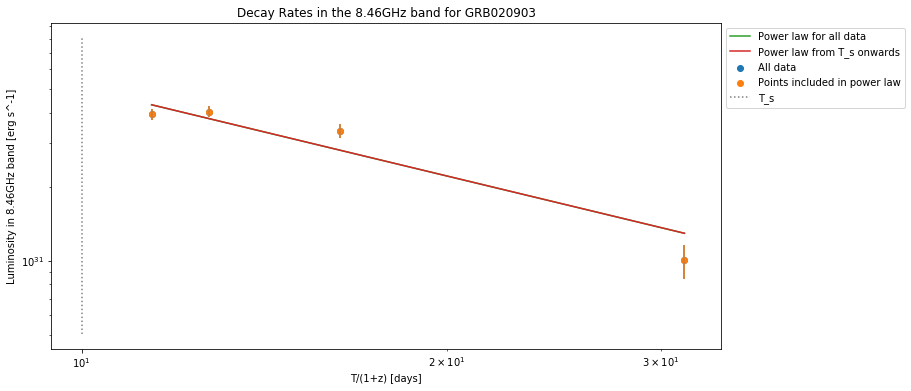

[[(0.68, 2.0360466072652365e+33), (0.0, 2.3758578966788333e+33), (0.68, 2.7788957317215177e+33)], [(0.68, -1.3789543563128674), (0.0, -1.3229724616652194), (0.68, -1.268736304188398)]]


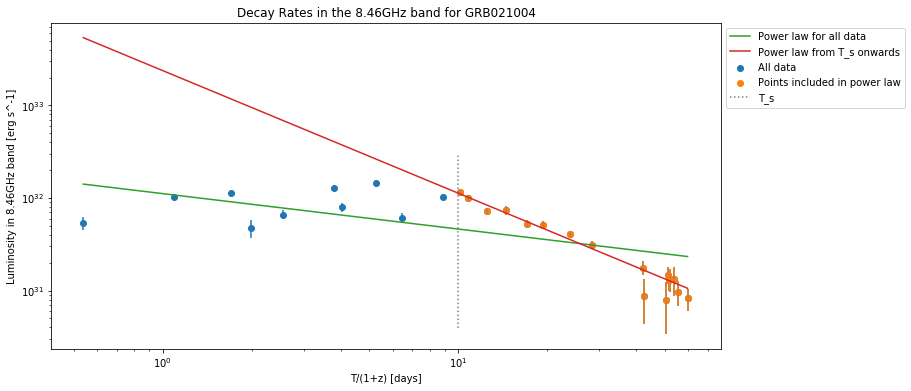

[[(0.68, 1.5669147161951551e+29), (0.0, 9.811744057158372e+30), (0.68, 3.6279236152454426e+32)], [(0.68, -1.005586484871773), (0.0, 0.07511652256582022), (0.68, 1.2857394734054914)]]


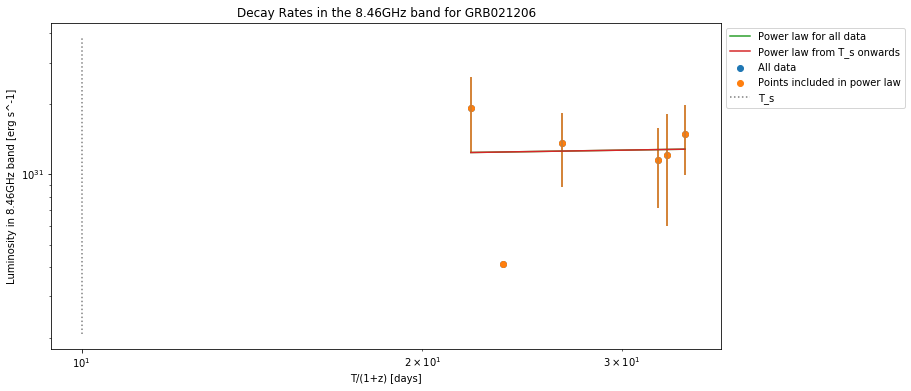

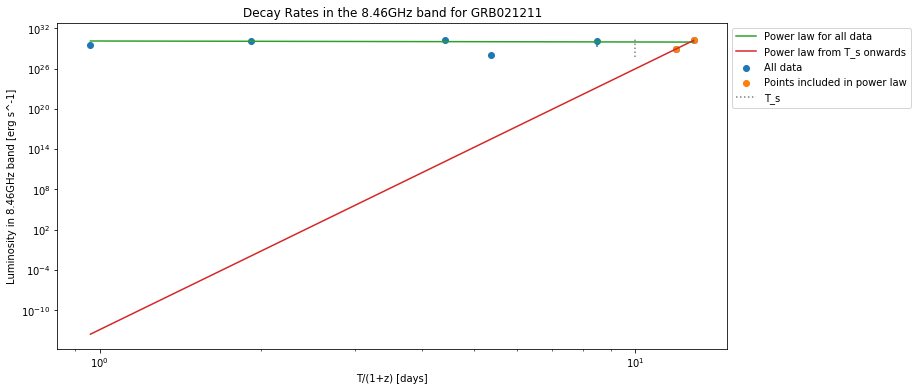

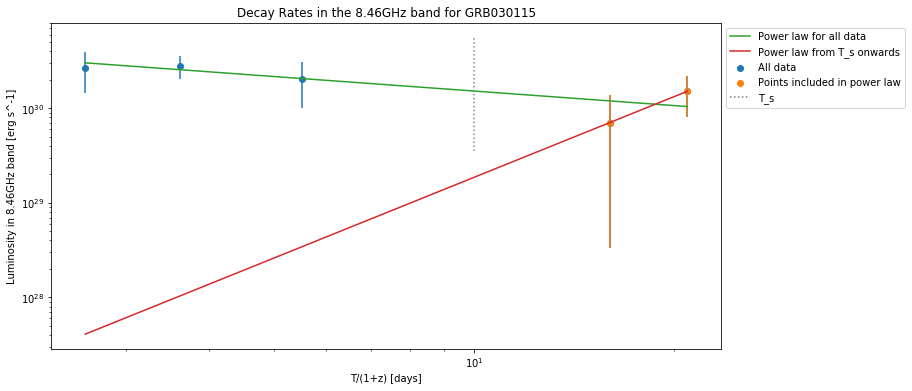

[[(0.68, 1.1475458068295651e+32), (0.0, 1.304658645890937e+32), (0.68, 1.4879229434340636e+32)], [(0.68, -0.9601227197094927), (0.0, -0.915994776163339), (0.68, -0.8743539313500752)]]


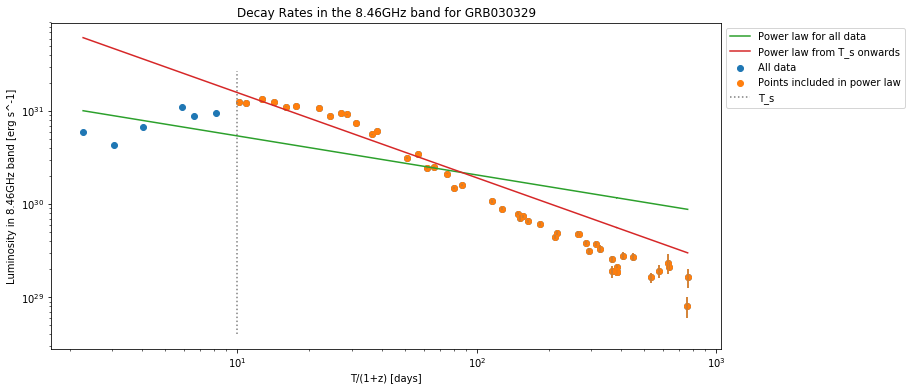

[[(0.68, 2.492007272768176e+29), (0.0, 2.180393651929232e+30), (0.68, 1.7678523049560388e+31)], [(0.68, -1.1872228979051573), (0.0, -0.6916814273474535), (0.68, -0.1974412270900614)]]


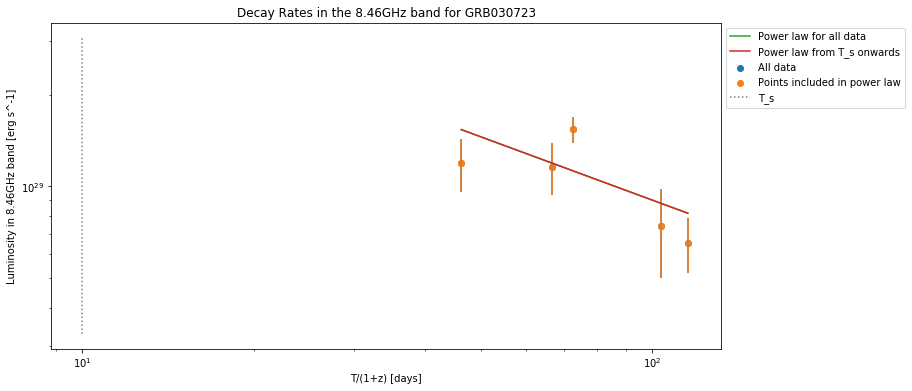

[[(0.68, 1.0556452352808225e+29), (0.0, 1.473451246292686e+29), (0.68, 2.0264313804309534e+29)], [(0.68, -0.12348601951300271), (0.0, -0.034821829029664964), (0.68, 0.05424065735609158)]]


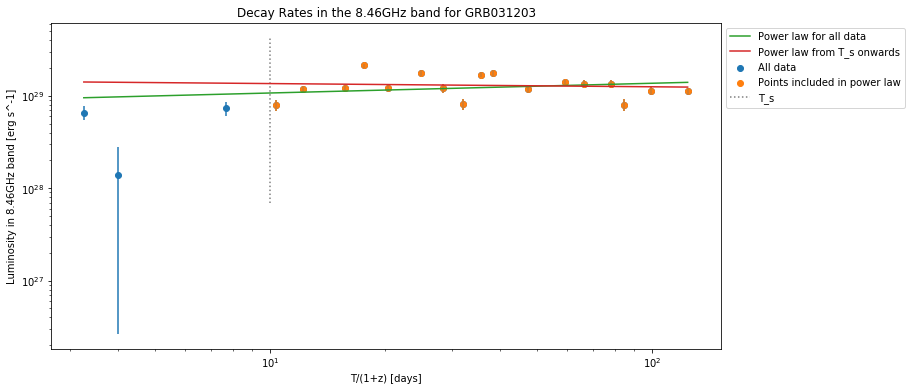

[[(0.68, 1.5163519934454745e+32), (0.0, 3.256902683185855e+32), (0.68, 7.332282735806593e+32)], [(0.68, -1.804593989517046), (0.0, -1.5895068924007867), (0.68, -1.388828994160205)]]


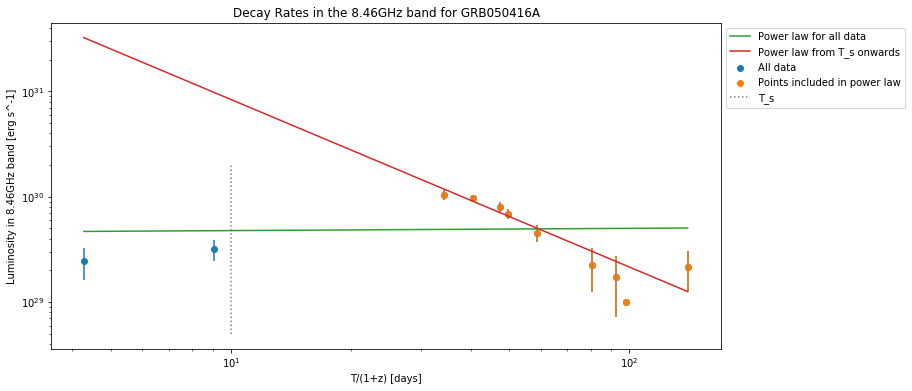

[[(0.68, 7.707404999724364e+29), (0.0, 1.7461882990801664e+31), (0.68, 6.931754046999089e+32)], [(0.68, -1.8716222168098213), (0.0, -0.8707574912083872), (0.68, -0.05604110687034175)]]


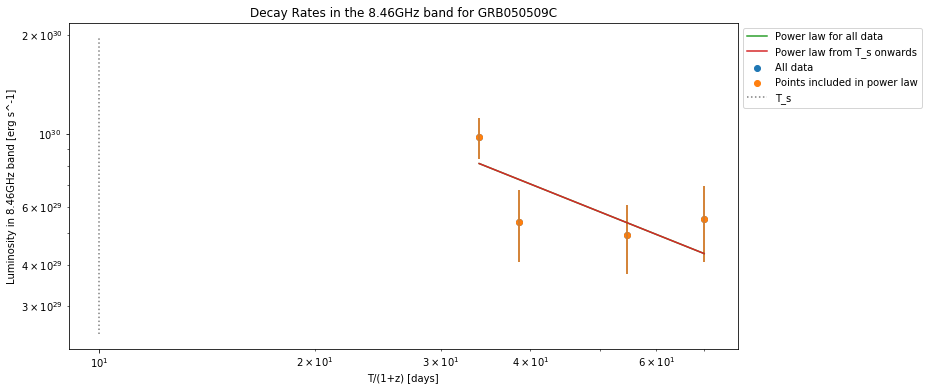

/Applications/anaconda3/lib/python3.6/site-packages/lmfit/confidence.py:310: UserWarning: maxiter=200 reached and prob(pow_amplitude=7.600604754704701e+30) = 0.6652009651852983 < max(sigmas).
  warn(errmsg)


[[(0.68, 1.5366989093737037e+27), (0.0, 1.8448069792972552e+29), (0.68, inf)], [(0.68, -1.295662064576018), (0.0, 0.17904588712767694), (0.68, 1.7681828311587047)]]


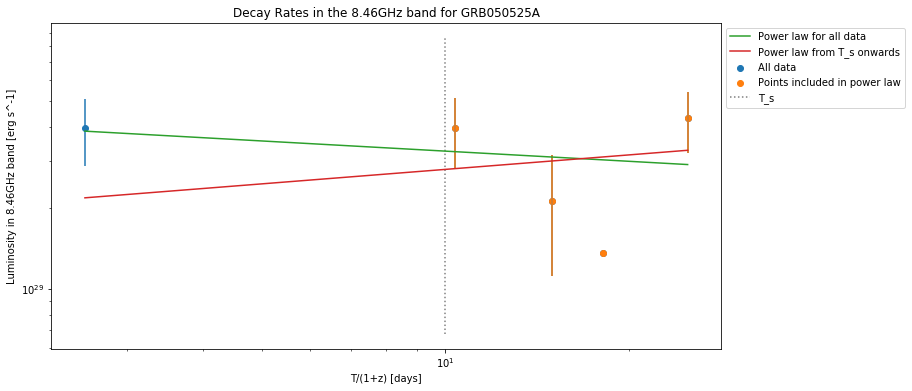

/Applications/anaconda3/lib/python3.6/site-packages/lmfit/confidence.py:310: UserWarning: maxiter=200 reached and prob(pow_amplitude=4.304679825304938e+31) = 0.49189400654084314 < max(sigmas).
  warn(errmsg)


[[(0.68, 5.162502340496789e+27), (0.0, 1.0448252003167342e+30), (0.68, inf)], [(0.68, -2.558520380243773), (0.0, -0.2881150660152959), (0.68, 1.3217591783525453)]]


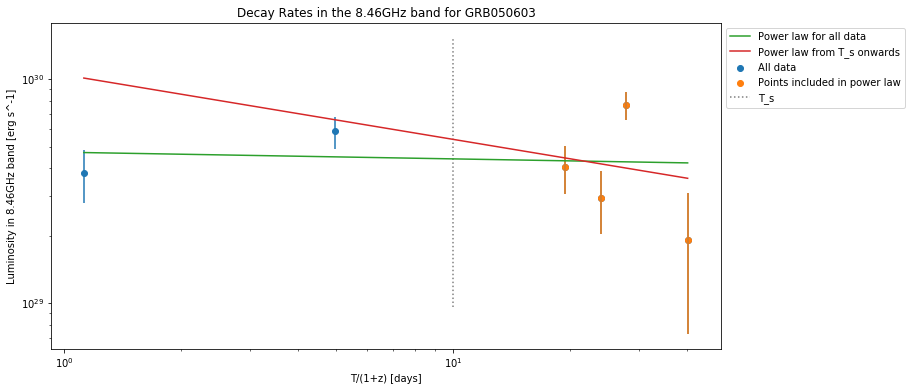

[[(0.68, 5.0050578301400343e+30), (0.0, 1.4036944237213437e+31), (0.68, 4.394078064626076e+31)], [(0.68, -1.582051142949547), (0.0, -1.1668356308673944), (0.68, -0.801386058593393)]]


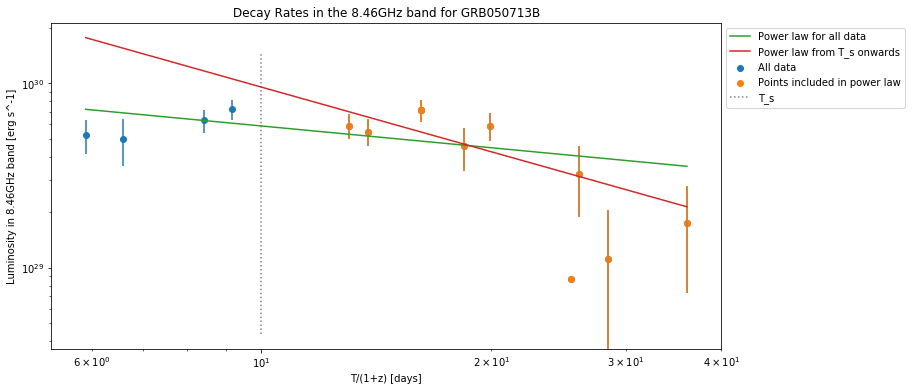

/Applications/anaconda3/lib/python3.6/site-packages/lmfit/confidence.py:310: UserWarning: maxiter=200 reached and prob(pow_amplitude=1.6048430170998121e+32) = 0.5876982687800388 < max(sigmas).
  warn(errmsg)


[[(0.68, 5.614285111560931e+28), (0.0, 3.895250041504386e+30), (0.68, inf)], [(0.68, -2.1686399634744613), (0.0, -0.266161769191147), (0.68, 1.268067935606115)]]


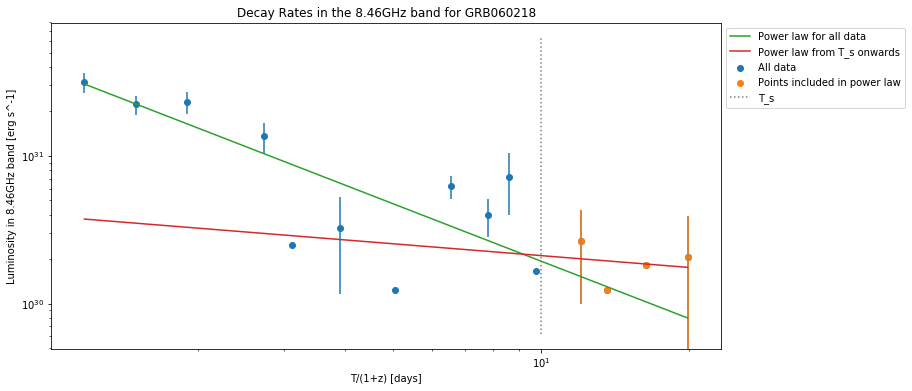

[[(0.68, 2.6066376692394304e+32), (0.0, 3.632272132980279e+32), (0.68, 5.069042474735288e+32)], [(0.68, -0.8775641734787442), (0.0, -0.7809433865273517), (0.68, -0.6890934813243311)]]


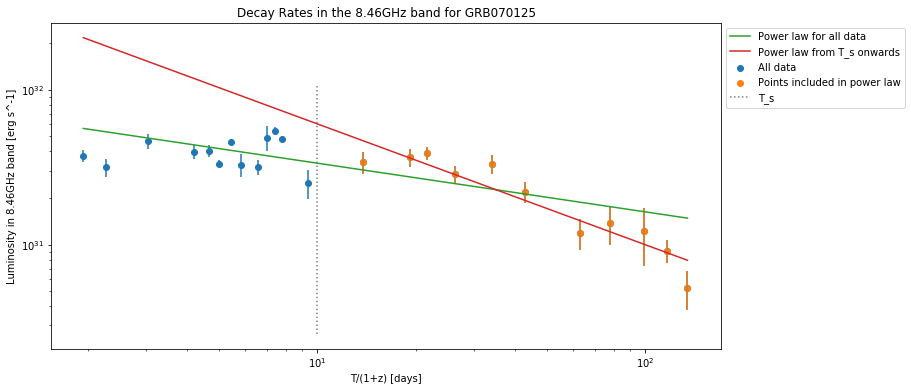

[[(0.68, 1.496572063652965e+32), (0.0, 2.1464823031809797e+32), (0.68, 3.130286866100239e+32)], [(0.68, -0.5123930311407409), (0.0, -0.3965509691955791), (0.68, -0.2912552183647149)]]


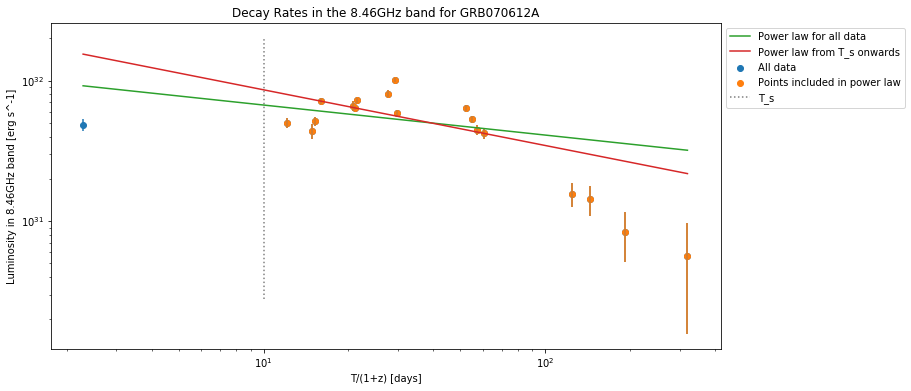

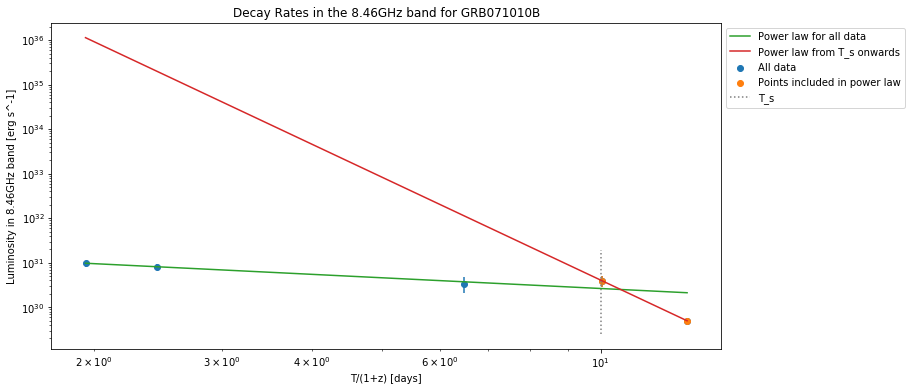

[[(0.68, 4.2599693347678953e+33), (0.0, 1.3999680152340458e+34), (0.68, 6.185715648769541e+34)], [(0.68, -3.4156594656954455), (0.0, -2.8139431726074657), (0.68, -2.3413713767974786)]]


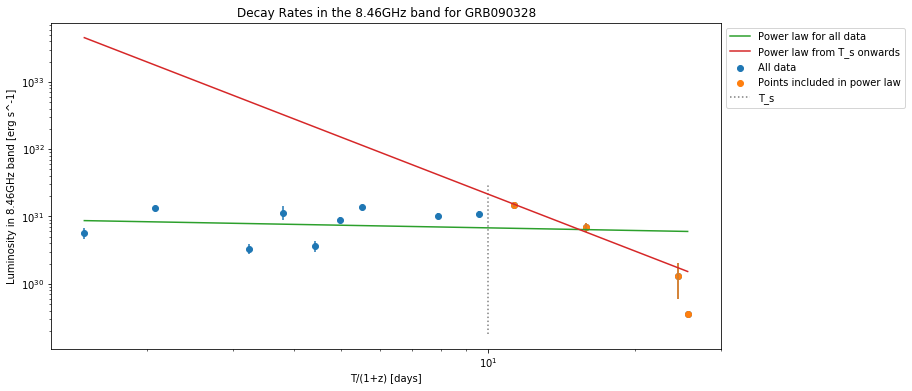

[[(0.68, 5.0244901297083376e+30), (0.0, 2.1383399476672138e+31), (0.68, 1.1445550546322723e+32)], [(0.68, -1.1672261976673988), (0.0, -0.58442404056981), (0.68, -0.12867640797846014)]]


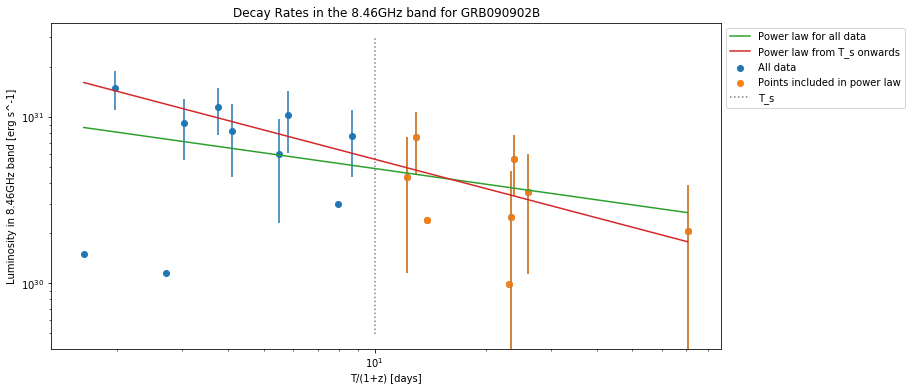

[[(0.68, 2.5756828834961006e+31), (0.0, 6.849382648547877e+31), (0.68, 1.9018768021666988e+32)], [(0.68, -1.0270014068909228), (0.0, -0.64204055460044), (0.68, -0.2849242870704844)]]


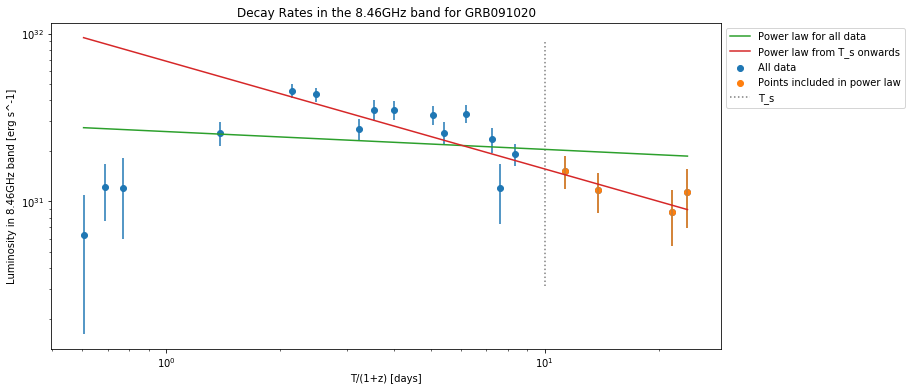

[[(0.68, 1.0506010816678328e+32), (0.0, 9.099451422339198e+32), (0.68, 2.3662039419735104e+34)], [(0.68, -3.1694735584410725), (0.0, -1.8581399920681942), (0.68, -1.0183839941168906)]]


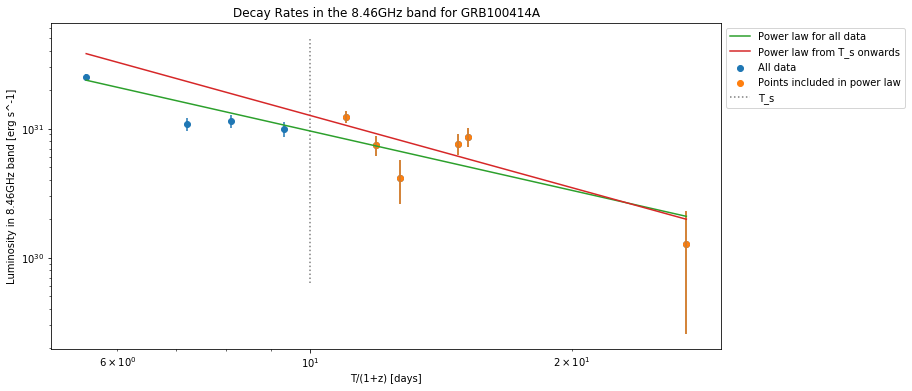

[[(0.68, 3.3751444991834486e+30), (0.0, 7.778739406184172e+30), (0.68, 1.7154275551846761e+31)], [(0.68, -0.16165344919248797), (0.0, 0.09214405210821455), (0.68, 0.3351650200811641)]]


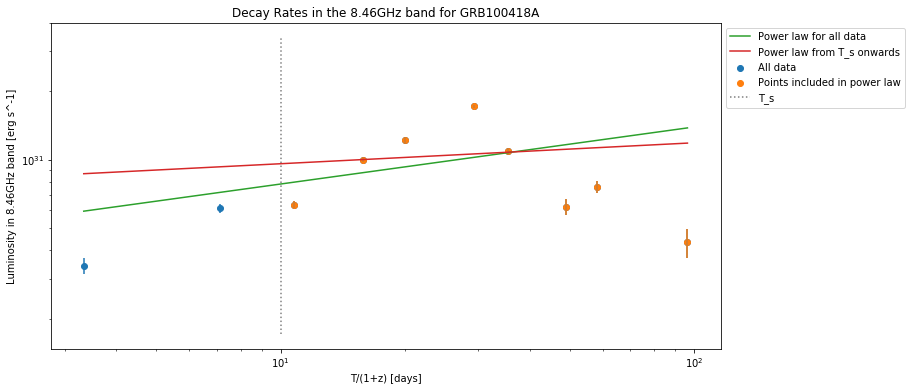

46


In [283]:
"""
PLOTTING A POWER LAW FOR ALL DATA
"""


# first GRB in the radio data with a redshift
first_GRB =  GRB_name[0]

# empty arrays to store data
time = []
flux = []
flux_err = []
GRB_plot_decay = []
decay_constant = []
decay_constant_data = []

# loop through rows in data for 8.46GHz
for row in data_freq:
    
    # get name of GRB for that row
    GRB = row[0]

    # if GRB matches previous, add it to the array
    if re.match(GRB, first_GRB):

        # Adds data to array for that GRB
        time.append(row[1])
        flux.append(row[2])
        flux_err.append(row[3])

        # identify redshift and luminosity distance for that GRB
        for j in GRB_z_d_l:

            x = j[0]

            if re.match(GRB, x):

                z = j[1]
                d_l = j[2]

            # when it stops matching, plot the data and reset the arrays  
    else:

        if len(flux) >= 3:


            # call on luminosity function to plot lum curves
            lum = L(flux, d_l, z, beta)
            lum_err = L_err(flux_err, d_l, z, beta)
            time_rest = T_rest(time, z)


            if time_rest[-2] > T_s:

                # removes lightcurves where less than three of the points have an error
                test_list = list(zip(lum, lum_err))
                x = 0
                for y in test_list:
                    if y[0] > y[1]:
                        x+=1

                if x > 2:

                    
                    # calculating best fit parameters and covariances for all the data

                    # call on weight function to get the weights of the luminosity errorss
                    weight_lum = weight(lum_err)

                    # making power law model for linear fits
                    model1 = PowerLawModel(prefix='pow_')

                    # make parameters with starting values
                    par1 = model1.make_params(pow_amplitude=1e31, pow_exponent=-0.5)

                    # create results for these parameters using the weights
                    result1 = model1.fit(lum, par1, x=time_rest, weights=weight_lum)

                    # get a and N from the results
                    a1_all = result1.best_values['pow_exponent']
                    N1_all = result1.best_values['pow_amplitude']

                    # call on power law function to create line with these parameters
                    decay_line_all = power_law1(time_rest, N1_all, a1_all)



                    # calculate best fit parameters for data beyond T_s

                    # empty array to store the differences between the time values and T_s
                    diff = []

                    # skip ones with only data before T_s
                    if time_rest[-1]<T_s:
                        continue

                    # if data before and after T_s, then find index of point after T_s
                    if time_rest[0]<T_s:

                        l_b = T_s

                        for T in time_rest:
                            if T<l_b:
                                l_b_idx = 1+ time_rest.index(T)

                        time_new = time_rest[l_b_idx:]
                        lum_new = lum[l_b_idx:]
                        lum_err_new = lum_err[l_b_idx:]


                    # if data doesn't extend beyond T_s
                    if time_rest[0]>T_s:

                        time_new = time_rest
                        lum_new = lum
                        lum_err_new = lum_err



                    # call on weight function to get the weights of the luminosity errorss
                    weight_lum_new = weight(lum_err_new)

                    # making power law model for linear fits
                    model1 = PowerLawModel(prefix='pow_')

                    # make parameters with starting values
                    par1 = model1.make_params(pow_amplitude=1e31, pow_exponent=-0.5)

                    # create results for these parameters using the weights
                    result1 = model1.fit(lum_new, par1, x=time_new, weights=weight_lum_new)

                    # get a and N from the results
                    a1 = result1.best_values['pow_exponent']
                    N1 = result1.best_values['pow_amplitude']

                    # call on power law function to create line with these parameters
                    decay_line = power_law1(time_rest, N1, a1)

                    
                    if time_rest[-4] > T_s: 
                        # get error on decay rate
                        ci = lmfit.conf_interval(result1, result1, sigmas=[0.68])
                        #lmfit.report_ci(ci)
                        #print('error')
                        #print(ci)

                        normcon = []

                        for key, value in ci.items():
                            normcon.append(value)

                        print(normcon)

                    # defining min and max values for plotting of T_s line
                    ymin_T_s = 0.5*min(lum)
                    ymax_T_s = 2*max(lum)



                    # plot scatter graph of the individual luminosity curves
                    plt.figure(figsize = (12, 6))
                    plt.title(f'Decay Rates in the 8.46GHz band for GRB{first_GRB}')
                    plt.xscale("log")
                    plt.xlabel("T/(1+z) [days]")
                    plt.yscale("log")
                    plt.ylabel("Luminosity in 8.46GHz band [erg s^-1]")
                    plt.scatter(time_rest, lum, label='All data')
                    plt.errorbar(time_rest, lum, yerr = lum_err, fmt = ' ')
                    plt.scatter(time_new, lum_new, label = 'Points included in power law')
                    plt.errorbar(time_new, lum_new, yerr = lum_err_new, fmt = ' ')
                    # plot the decay line for all data
                    plt.plot(time_rest, decay_line_all, label='Power law for all data')
                    # plot the decay line for data beyond T_s
                    plt.plot(time_rest, decay_line, label='Power law from T_s onwards')
                    # plot a line showing T
                    plt.vlines(x=10, ymin=ymin_T_s, ymax=ymax_T_s, colors='grey', linestyle=':', label='T_s')
                    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
                    plt.show()

                    # only stores the decay constants if there are points beyond T_s
                    if time_rest[-1]>T_s:
                        decay_constant_data.append([first_GRB, a1])
                        decay_constant.append(a1)
                        GRB_plot_decay.append(first_GRB)

        # reset the arrays
        time = []
        flux = []
        flux_err = []

        # move to next GRB
        first_GRB = GRB
        continue
        
print(len(decay_constant))

970111
[20.0, 20.0, 40.0]
[8.46, 8.46, 8.46]


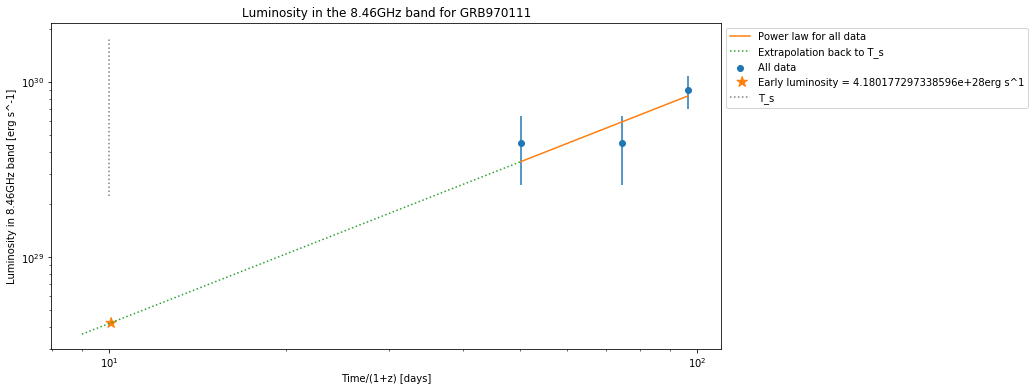

970228
[54.0, 20.0, 55.0, 40.0, 2.0, 4.0, 55.0, 25.0, 23.0, 13.0, 35.0, 25.0, 13.0, 12.0]
[50.0, 40.0, 8.46, 8.46, 36.0, 12.0, 30.0, 8.46, 8.46, 26.0, 8.46, 19.0, 8.46, 8.46]


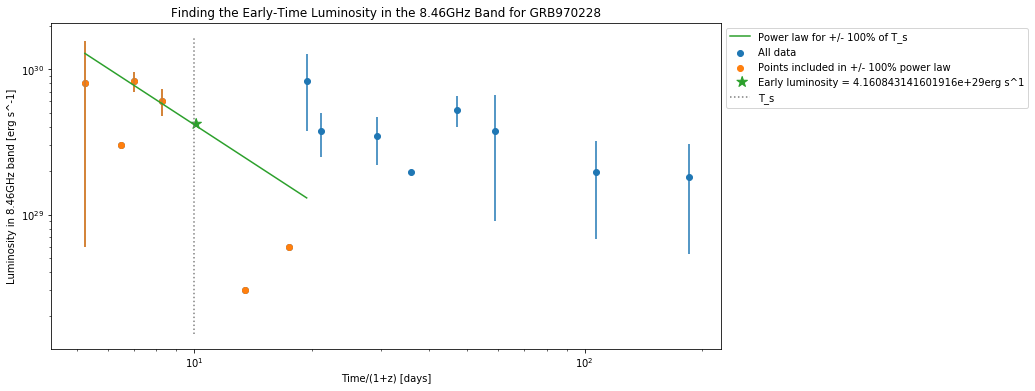

Early-time luminosity of GRB970228 is 4.160843141601916e+29erg s^-1
970508
[610.0, 520.0, 602.0, 604.0, 610.0, 1270.0, 930.0, 570.0, 880.0, 1260.0, 960.0, 550.0, 470.0, 480.0, 500.0, 538.0, 835.0, 1200.0, 810.0, 290.0, 720.0, 940.0, 960.0, 760.0, 670.0, 690.0, 530.0, 600.0, 460.0, 560.0, 630.0, 800.0, 645.0, 680.0, 565.0, 805.0, 710.0, 725.0, 680.0, 630.0, 575.0, 515.0, 440.0, 455.0, 380.0, 445.0, 430.0, 640.0, 565.0, 400.0, 300.0, 470.0, 315.0, 355.0, 370.0, 350.0, 370.0, 330.0, 310.0, 280.0, 240.0, 300.0, 240.0, 240.0, 170.0, 160.0, 150.0, 50.0, 50.0, 95.0, 105.0, 25.0, 37.0, 8.0]
[33.0, 18.0, 24.0, 56.0, 51.0, 120.0, 120.0, 42.0, 33.0, 100.0, 100.0, 44.0, 43.0, 45.0, 49.0, 100.0, 100.0, 47.0, 48.0, 46.0, 62.0, 27.0, 40.0, 45.0, 43.0, 28.0, 38.0, 39.0, 66.0, 40.0, 63.0, 32.0, 38.0, 46.0, 36.0, 43.0, 49.0, 40.0, 46.0, 37.0, 61.0, 41.0, 51.0, 85.0, 42.0, 50.0, 39.0, 40.0, 49.0, 60.0, 35.0, 44.0, 70.0, 47.0, 70.0, 47.0, 39.0, 45.0, 56.0, 37.0, 34.0, 37.0, 24.0, 30.0, 30.0, 30.0, 36.0, 8

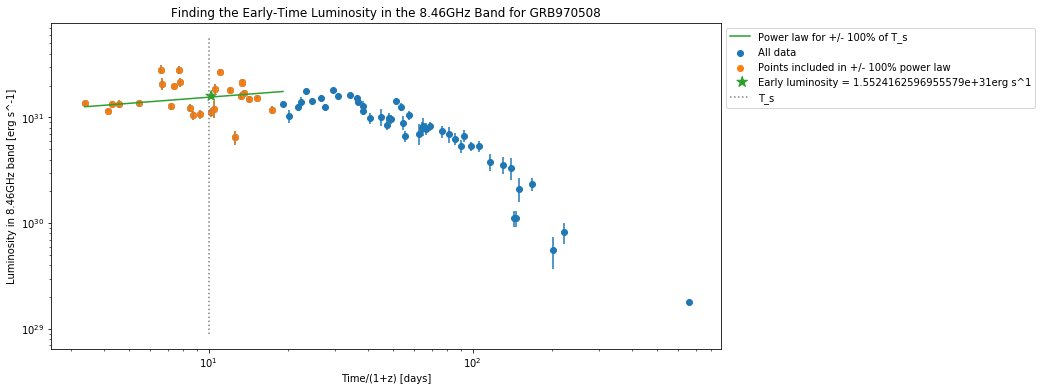

Early-time luminosity of GRB970508 is 1.5524162596955579e+31erg s^-1
970616
[50.0, 60.0, 40.0, 40.0, 40.0]
[8.46, 8.46, 8.46, 8.46, 8.46]
970815
[62.0, 24.0, 24.0, 16.0]
[8.44, 8.44, 8.44, 8.44]


IndexError: list index out of range

In [45]:
"""
FINDING THE EARLY LUMINOSITY
"""

# first GRB in the radio data with a redshift
first_GRB =  GRB_name[0]

# empty arrays to store data
time = []
flux = []
flux_err = []
GRB_plot_earlyl = []
early_lums_data_2 = []
early_lums_data_100p = []
early_lums_data_5 = []

# loop through rows in data for 8.46GHz
for row in data_freq:
    
    # get name of GRB for that row
    GRB = row[0]

    # if GRB matches previous, add it to the array
    if re.match(GRB, first_GRB):

        # Adds data to array for that GRB
        time.append(row[1])
        flux.append(row[2])
        flux_err.append(row[3])

        # identify redshift and luminosity distance for that GRB
        for j in GRB_z_d_l:

            x = j[0]

            if re.match(GRB, x):

                z = j[1]
                d_l = j[2]

    # when it stops matching, plot the data and reset the arrays  
    else:

        if len(flux) >= 3:

            print(first_GRB)
            print(flux)
            print(flux_err)
            # call on luminosity function to plot lum curves
            lum = L(flux, d_l, z, beta)
            lum_err = L_err(flux_err, d_l, z, beta)
            time_rest = T_rest(time, z)

            if time_rest[-2] > T_s:

                # removes lightcurves where less than three of the points have an error
                test_list = list(zip(lum, lum_err))
                x = 0
                for y in test_list:
                    if y[0] > y[1]:
                        x+=1

                if x > 2:

                    # defining min and max values for plotting of T_s line
                    ymin_T_s = 0.5*min(lum)
                    ymax_T_s = 2*max(lum)


                    # if there are only points beyond T_s, then extrapolate power law back
                    if time_rest[0]>T_s:

                        # call on weight function to get the weights of the luminosity errorss
                        weight_lum = weight(lum_err)

                        # making power law model for linear fits
                        model1 = PowerLawModel(prefix='pow_')

                        # make parameters with starting values
                        par1 = model1.make_params(pow_amplitude=1e30, pow_exponent=-0.5)

                        # create results for these parameters using the weights
                        result1 = model1.fit(lum, par1, x=time_rest, weights=weight_lum)

                        # get a and N from the results
                        a1 = result1.best_values['pow_exponent']
                        N1 = result1.best_values['pow_amplitude']

                        # call on power law function to create line with these parameters
                        decay_line = power_law1(time_rest, N1, a1)

                        # create power law that extrapolates back to T_s
                        time_extrap = np.linspace(T_s - 1, time_rest[0], num = 1000)
                        decay_line_extrap = power_law1(time_extrap, N1, a1)

                        # Finding the luminosity at T_s
                        diff = []
                        for T in time_extrap:
                            diff.append(abs(T-T_s))

                        idx_T_s = np.argmin(diff)
                        early_lum = decay_line_extrap[idx_T_s]



                        # plot scatter graph of the individual luminosity curves
                        plt.figure(figsize = (12, 6))
                        plt.title(f'Luminosity in the 8.46GHz band for GRB{first_GRB}')
                        plt.xscale("log")
                        plt.xlabel("Time/(1+z) [days]")
                        plt.yscale("log")
                        plt.ylabel("Luminosity in 8.46GHz band [erg s^-1]")
                        plt.scatter(time_rest, lum, label='All data')
                        plt.errorbar(time_rest, lum, yerr = lum_err, fmt = ' ')
                        # plot the decay line for data beyond T_s
                        plt.plot(time_rest, decay_line, label='Power law for all data')
                        # plot extrapolated line to get early luminosity from
                        plt.plot(time_extrap, decay_line_extrap, linestyle=':', label='Extrapolation back to T_s')
                        # plot the early luminosity point
                        plt.scatter(T_s, early_lum, marker=r'$\star$', s=200, label = f'Early luminosity = {early_lum}erg s^1')
                        # plot a line showing T
                        plt.vlines(x=10, ymin=ymin_T_s, ymax=ymax_T_s, colors='grey', linestyle=':', label='T_s')
                        plt.legend(bbox_to_anchor=(1,1), loc="upper left")
                        plt.show()

                        # adds GRB to list if luminosity curve is plot
                        GRB_plot_earlyl.append(first_GRB)

                        # add luminositites to an array, with type 'E' for extrapolated
                        early_lums_data_2.append([first_GRB, early_lum, 'E'])
                        early_lums_data_100p.append([first_GRB, early_lum, 'E'])
                        early_lums_data_5.append([first_GRB, early_lum, 'E'])

                    # if there are only points before T_s, then skip
                    if time_rest[-1]<T_s:
                        continue

                    # if there are points before and after T_s, then find the luminosity at T_s
                    if time_rest[0]<T_s:

                        # fitting power law to the two points arond T_s
                        for T in time_rest:
                            if T<T_s:
                                l_b_idx = time_rest.index(T)

                        u_b_idx = l_b_idx + 2

                        time_2 = time_rest[l_b_idx:u_b_idx]
                        lum_2 = lum[l_b_idx:u_b_idx]
                        lum_err_2 = lum_err[l_b_idx:u_b_idx]


                        # fitting power law to T_s + 100% T_s
                        u_b_100p = 20

                        for T in time_rest:
                            if T<u_b_100p:
                                u_b_idx_100p = time_rest.index(T)

                        l_b_idx_100p = 0

                        time_100p = time_rest[l_b_idx_100p:u_b_idx_100p]
                        lum_100p = lum[l_b_idx_100p:u_b_idx_100p]
                        lum_err_100p = lum_err[l_b_idx_100p:u_b_idx_100p]
                        
                        """
                        # fitting power law from 5 to 50 days
                        u_b_5 = 50
                        l_b_5 = 5

                        for T in time_rest:
                            if T<u_b_5:
                                u_b_idx_5 = time_rest.index(T)
                            if T<l_b_5:
                                l_b_idx_5 = time_rest.index(T)

                        time_5 = time_rest[l_b_idx_5:u_b_idx_5]
                        lum_5 = lum[l_b_idx_5:u_b_idx_5]
                        lum_err_5 = lum_err[l_b_idx_5:u_b_idx_5]
                        """
                        if time_100p[-1] > T_s:

                            # calculating best fit parameters and covariances for the data lmfit

                            # making power law model for linear fits
                            model = PowerLawModel(prefix='pow_')

                            # make parameters with starting values
                            par = model.make_params(pow_amplitude=1e31, pow_exponent=-0.3)

                            # call on weight function to get the weights of the luminosity errorss
                            weight_lum_2 = weight(lum_err_2)
                            weight_lum_100p = weight(lum_err_100p)
                            #weight_lum_5 = weight(lum_err_5)

                            # create results for these parameters using the weights
                            result_2 = model.fit(lum_2, par, x=time_2, weights=weight_lum_2)
                            result_100p = model.fit(lum_100p, par, x=time_100p, weights=weight_lum_100p)
                            #result_5 = model.fit(lum_5, par, x=time_5, weights=weight_lum_5)

                            # get a and N from the results
                            a_2 = result_2.best_values['pow_exponent']
                            N_2 = result_2.best_values['pow_amplitude']

                            a_100p = result_100p.best_values['pow_exponent']
                            N_100p = result_100p.best_values['pow_amplitude']

                            #a_5 = result_5.best_values['pow_exponent']
                            #N_5 = result_5.best_values['pow_amplitude']

                            time_plot_2 = np.linspace(time_rest[l_b_idx], time_rest[l_b_idx+1], num=1000)
                            time_plot_100p = np.linspace(time_rest[l_b_idx_100p], time_rest[u_b_idx_100p], num=1000)
                            #time_plot_5 = np.linspace(time_rest[l_b_idx_5], time_rest[u_b_idx_5], num=1000)

                            # call on power law function to create line with these parameters
                            decay_line_2 = power_law1(time_plot_2, N_2, a_2)
                            decay_line_100p = power_law1(time_plot_100p, N_100p, a_100p)
                            #decay_line_5 = power_law1(time_plot_5, N_5, a_5)

                            # Finding the luminosity at T_s for two points
                            diff = []
                            for T in time_plot_2:
                                diff.append(abs(T-T_s))

                            idx_T_s = np.argmin(diff)
                            early_lum_2 = decay_line_2[idx_T_s]

                            # Finding the luminosity at T_s for 100p
                            diff_100p = []
                            for T in time_plot_100p:
                                diff_100p.append(abs(T-T_s))

                            idx_T_s_100p = np.argmin(diff_100p)
                            early_lum_100p = decay_line_100p[idx_T_s_100p]

                            # Finding the luminosity at T_s for 5-50
                            """
                            diff_5 = []
                            for T in time_plot_5:
                                diff_5.append(abs(T-T_s))

                            idx_T_s_5 = np.argmin(diff_5)
                            early_lum_5 = decay_line_5[idx_T_s_5]
                            """


                            # plot scatter graph of the individual luminosity curves
                            plt.figure(figsize = (12, 6))
                            plt.title(f'Finding the Early-Time Luminosity in the 8.46GHz Band for GRB{first_GRB}')
                            plt.xscale("log")
                            plt.xlabel("Time/(1+z) [days]")
                            plt.yscale("log")
                            plt.ylabel("Luminosity in 8.46GHz band [erg s^-1]")
                            plt.scatter(time_rest, lum, label='All data')
                            plt.errorbar(time_rest, lum, yerr = lum_err, fmt = ' ')
                            # colour in points used in the fits
                            #plt.scatter(time_2, lum_2, label = 'Points included in two point power law')
                            #plt.errorbar(time_2, lum_2, yerr = lum_err_2, fmt = ' ')
                            plt.scatter(time_100p, lum_100p, label = 'Points included in +/- 100% power law')
                            plt.errorbar(time_100p, lum_100p, yerr = lum_err_100p, fmt = ' ')
                            #plt.scatter(time_5, lum_5, label = 'Points included from 5 to 50 days')
                            #plt.errorbar(time_5, lum_5, yerr = lum_err_5, fmt = ' ')
                            # plot the early luminosity point
                            #plt.scatter(T_s, early_lum_2, marker=r'$\star$', s=200, label = 'Early luminosity (two points)')
                            plt.scatter(T_s, early_lum_100p, marker=r'$\star$', s=200, label = f'Early luminosity = {early_lum_100p}erg s^1')
                            #plt.scatter(T_s, early_lum_5, marker=r'$\star$', s=200, label = 'Early luminosity (5 to 50 days)')
                            # plot the decay line between the two points around T_s
                            #plt.plot(time_plot_2, decay_line_2, label='Power law for two points either side of T_s')
                            plt.plot(time_plot_100p, decay_line_100p, label='Power law for +/- 100% of T_s')
                            #plt.plot(time_plot_5, decay_line_5, label='Power law from 5 to 50 days')
                            # plot a line showing T_s
                            plt.vlines(x=T_s, ymin=ymin_T_s, ymax=ymax_T_s, colors='grey', linestyle=':', label='T_s')
                            plt.legend(bbox_to_anchor=(1,1), loc="upper left")
                            plt.show()


                            print(f'Early-time luminosity of GRB{first_GRB} is {early_lum_100p}erg s^-1')

                            # adds GRB to list if luminosity curve is plot
                            GRB_plot_earlyl.append(first_GRB)

                            # add luminositites to an array, with type 'R' for regular method
                            early_lums_data_2.append([first_GRB, early_lum_2, 'R'])
                            early_lums_data_100p.append([first_GRB, early_lum_100p, 'R'])
                            #early_lums_data_5.append([first_GRB, early_lum_5, 'R'])

        # reset the arrays
        time = []
        flux = []
        flux_err = []

        # move to next GRB
        first_GRB = GRB
        continue

print(len(early_lums_data_2))        

start
end


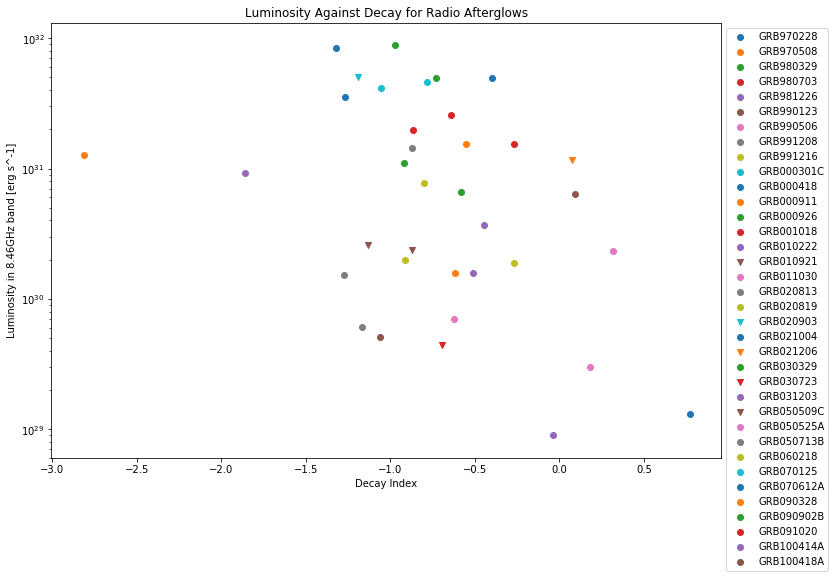

-0.3335907335907336
0.046781727994940236


KeyError: 'E'

In [290]:
"""
PLOT OF LUMINOSITY AGAINST DECAY
"""

# empty arrays to store the data
plot = []
plot_100p = []
plot_cut_100p = []
alpha_cut_100p = []
early_L_cut_100p = []
alpha_cut_100p_R = []
early_L_cut_100p_R = []

# cycle through the GRBs to match the early luminosity to decay rate
for row in early_lums_data_2:
    
    GRB = row[0]
    
    for line in decay_constant_data:
        
        # match names in decay list and luminosity list
        if GRB == line[0]:
            
            method = row[2]
            early_L = row[1]
            alpha = line[1]
            
            # add to new array to be plot
            plot.append([GRB, early_L, method, alpha])

            
            
# cycle through the GRBs to match the early luminosity to decay rate (+/- 100%)
for row in early_lums_data_100p:
    
    GRB = row[0]
    
    for line in decay_constant_data:
        
        # match names in decay list and luminosity list
        if GRB == line[0]:
            
            method = row[2]
            early_L = row[1]
            alpha = line[1]
            plot_100p.append([GRB, early_L, method, alpha])
            
            if alpha < 3:
                
                if alpha > -3:
            
                    # add to new array to be plot
                    plot_cut_100p.append([GRB, early_L, method, alpha])
                    alpha_cut_100p.append(alpha)
                    early_L_cut_100p.append(early_L)
                    
                    if method == 'R':
                        alpha_cut_100p_R.append(alpha)
                        early_L_cut_100p_R.append(early_L)

alpha_long = []
early_lum_long = []
plot_long = []
                        
print('start')                        
for row in early_lums_data_100p:
    GRB = row[0]
    
    if GRB in GRB_list:
        
        for line in decay_constant_data:
        
            # match names in decay list and luminosity list
            if GRB == line[0]:
                method = row[2]
                early_L = row[1]
                alpha = line[1]
                
                if alpha < 3:
                
                    if alpha > -3:
                        
                        if method == 'R':
                            plot_long.append([GRB, early_L, alpha])
                            alpha_long.append(alpha)
                            early_lum_long.append(early_L)
print('end')

# plot scatter graph of early luminosity against decay showing difference between extrapolated L's and regular ones (+/- 100%)
plt.figure(figsize = (12, 8))
plt.title(f'Luminosity Against Decay for Radio Afterglows')
plt.xlabel("Decay Index")
plt.yscale("log")
plt.ylabel("Luminosity in 8.46GHz band [erg s^-1]")

# cycle through data to plot
for data in plot_cut_100p:
    GRB = data[0]
    E_L = data[1]
    method = data[2]
    alpha = data[3]
    
    # if early lum found via regular method, plot as a dot
    if method == 'R':
        plt.scatter(alpha, E_L, label = f'GRB{GRB}') 

    # if early lum found via extrapolation method, plot as an upside-down triangle
    if method == 'E':
        plt.scatter(alpha, E_L, marker='v', label = f'GRB{GRB}')
    
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()  



rho, p = spearmanr(alpha_cut_100p, early_L_cut_100p)

print(rho)
print(p)

# plot scatter graph of early luminosity against decay excluding extrapolation values (+/- 100%)
plt.figure(figsize = (12, 8))
plt.title(f'Luminosity Against Decay for Radio Afterglows excluding extrapolation values')
plt.xlabel("Decay Index")
plt.yscale("log")
plt.ylabel("Luminosity in 8.46GHz band [erg s^-1]")

# cycle through data to plot
for data in plot_cut_100p:
    GRB = data[0]
    E_L = data[1]
    alpha = data[2]
    
    # if early lum found via regular method, plot as a dot
    if method == 'R':
        plt.scatter(alpha, E_L, label = f'GRB{GRB}') 
    
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()  



rho2, p2 = spearmanr(alpha_cut_100p_R, early_L_cut_100p_R)

print(rho2)
print(p2)


# plot scatter graph of early luminosity against decay excluding extrapolation values and only long GRBs (+/- 100%)
plt.figure(figsize = (12, 8))
plt.title(f'Luminosity Against Decay for Radio Afterglows excluding extrapolation values and SHB, XRF and GRB/SNe')
plt.xlabel("Decay Index")
plt.yscale("log")
plt.ylabel("Luminosity in 8.46GHz band [erg s^-1]")

# cycle through data to plot
for data in plot_long:
    GRB = data[0]
    E_L = data[1]
    alpha = data[2]
    
    plt.scatter(alpha, E_L, label = f'GRB{GRB}') 
    
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()  



rho3, p3 = spearmanr(alpha_long, early_lum_long)

print(rho3)
print(p3)



"""
# separate data for use in plot of all (two points)
L = []
alpha = []
for data in plot:
    L.append(data[1])
    alpha.append(data[3])        

# plot scatter graph of early luminosity against decay 
plt.figure(figsize = (12, 8))
plt.title(f'Luminosity Against Decay for Radio Afterglows (All, two points)')
plt.xlabel("Decay Index")
plt.yscale("log")
plt.ylabel("Luminosity in 8.46GHz band [erg s^-1]")
plt.scatter(alpha, L)
plt.show()


# separate data for use in plot of all (+/- 100%)
L_100p = []
alpha_100p = []
for data in plot_100p:
    L_100p.append(data[1])
    alpha_100p.append(data[3])        

# plot scatter graph of early luminosity against decay 
plt.figure(figsize = (12, 8))
plt.title(f'Luminosity Against Decay for Radio Afterglows (All, +/- 100%)')
plt.xlabel("Decay Index")
plt.yscale("log")
plt.ylabel("Luminosity in 8.46GHz band [erg s^-1]")
plt.scatter(alpha_100p, L_100p)
plt.show()            

    
# plot scatter graph of early luminosity against decay showing difference between extrapolated L's and regular ones (two points)
plt.figure(figsize = (12, 8))
plt.title(f'Luminosity Against Decay for Radio Afterglows (Symbols, two points)')
plt.xlabel("Decay Index")
plt.yscale("log")
plt.ylabel("Luminosity in 8.46GHz band [erg s^-1]")

# cycle through data to plot
for data in plot:
    GRB = data[0]
    L = data[1]
    method = data[2]
    alpha = data[3]
    
    if alpha < 2:
    
        # if early lum found via regular method, plot as a dot
        if method == 'R':
            plt.scatter(alpha, L, label = f'{GRB}') 

        # if early lum found via extrapolation method, plot as an upside-down triangle
        if method == 'E':
            plt.scatter(alpha, L, marker='v', label = f'{GRB}')
    
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()  
"""
  
